In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from scipy.spatial import procrustes
from scipy.spatial.distance import jensenshannon

In [58]:
plt.style.use('ggplot')

In [59]:
data=pd.read_csv('combined_data_with_loc.csv')
data.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


In [60]:
#load feature category mapping
feature_category_dict=json.load(open('feature_category_dict.json'))
feature_category_dict

{'2007 population': ['2007 ERP age 0-4, persons',
  '2007 ERP age 0-4, %',
  '2007 ERP age 5-9, persons',
  '2007 ERP age 5-9, %',
  '2007 ERP age 10-14, persons',
  '2007 ERP age 10-14, %',
  '2007 ERP age 15-19, persons',
  '2007 ERP age 15-19, %',
  '2007 ERP age 20-24, persons',
  '2007 ERP age 20-24, %',
  '2007 ERP age 25-44, persons',
  '2007 ERP age 25-44, %',
  '2007 ERP age 45-64, persons',
  '2007 ERP age 45-64, %',
  '2007 ERP age 65-69, persons',
  '2007 ERP age 65-69, %',
  '2007 ERP age 70-74, persons',
  '2007 ERP age 70-74, %',
  '2007 ERP age 75-79, persons',
  '2007 ERP age 75-79, %',
  '2007 ERP age 80-84, persons',
  '2007 ERP age 80-84, %',
  '2007 ERP age 85+, persons',
  '2007 ERP age 85+, %',
  '2007 ERP, total'],
 '2007-2012 population change': ['% change, 2007-2012, age 0-4',
  '% change, 2007-2012, age 5-9',
  '% change, 2007-2012, age 10-14',
  '% change, 2007-2012, age 15-19',
  '% change, 2007-2012, age 20-24',
  '% change, 2007-2012, age 25-44',
  '% cha

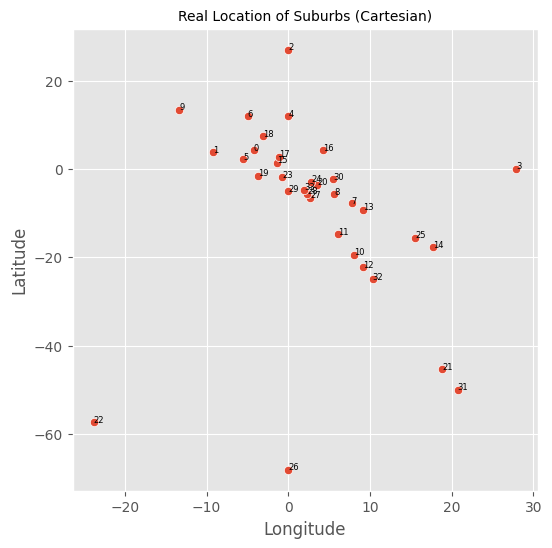

In [61]:
# do a similar plot for the real location of the suburbs
plt.figure(figsize=(6,6))
sns.scatterplot(x='cart_x',y='cart_y',data=data)
plt.title('Real Location of Suburbs (Cartesian)',fontsize=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# annotate the suburbs with the suburb index
for i in range(data.shape[0]):
	plt.text(data['cart_x'].iloc[i],data['cart_y'].iloc[i],i,fontsize=6)
plt.show()
# print the stress of the MDS



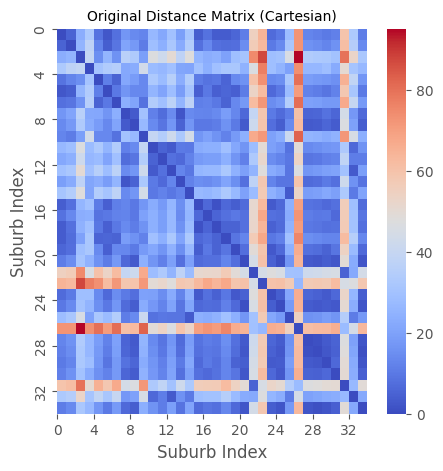

In [62]:
# pairwise distance between the original location
distance_original=np.zeros((data.shape[0],data.shape[0]))
for i in range(data.shape[0]):
	for j in range(data.shape[0]):
		distance_original[i,j]=np.sqrt((data['cart_x'].iloc[i]-data['cart_x'].iloc[j])**2+(data['cart_y'].iloc[i]-data['cart_y'].iloc[j])**2)

# plot the distance matrix
plt.figure(figsize=(5,5))
sns.heatmap(distance_original,cmap='coolwarm')
plt.title('Original Distance Matrix (Cartesian)',fontsize=10)
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
# ticks every 4th
plt.xticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.yticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))

plt.show()

# Perspective 1: Services Provided

In [63]:
# load the category 'Services'
category='Services'
features=feature_category_dict[category]
features

['Public Hospitals',
 'Private Hospitals',
 'Community Health Centres',
 'Bush Nursing Centres',
 'Allied Health',
 'Alternative Health',
 'Child Protection and Family',
 'Dental',
 'Disability',
 'General Practice',
 'Homelessness',
 'Mental Health',
 'Pharmacies',
 'Aged Care (High Care)',
 'Aged Care (Low Care)',
 'Aged Care (SRS)',
 'Kinder and/or Childcare',
 'Primary Schools',
 'Secondary Schools',
 'P12 Schools',
 'Other Schools',
 'Centrelink Offices',
 'Medicare Offices',
 'Medicare Access Points']

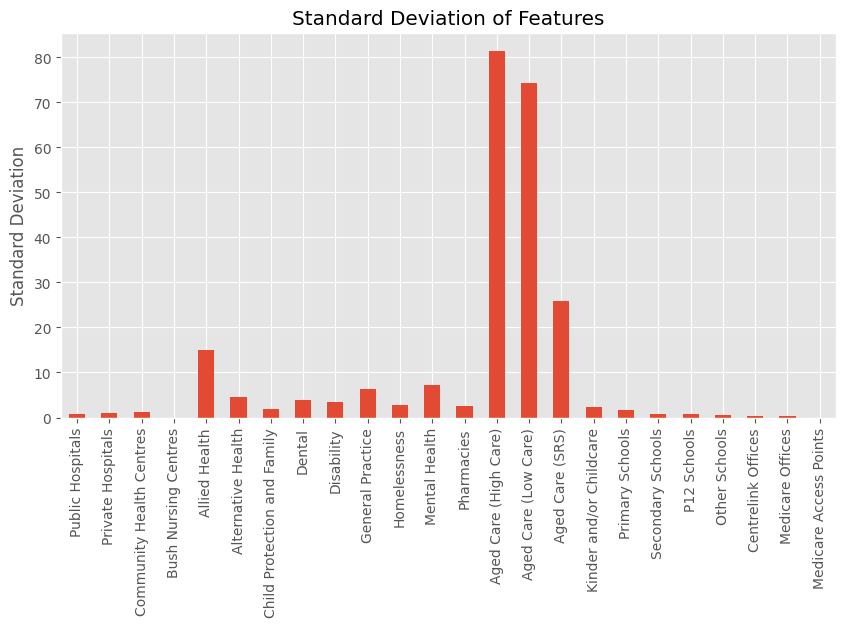

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0,1,1,0,10,5,0,0,0,2,...,31,0,4,3,0,0,1,0,0,0
1,0,0,1,0,13,1,0,1,1,4,...,0,0,1,2,2,0,1,0,0,0
2,1,0,1,0,15,0,0,1,1,8,...,0,0,2,6,1,1,0,0,0,0
3,0,1,0,0,30,8,0,7,9,9,...,179,45,10,5,2,0,0,0,0,0
4,0,0,1,0,13,1,0,1,0,5,...,150,0,3,4,1,1,0,0,0,0


In [64]:
# extract the data for the category 'Services'
data_services=data[features]
# plot the standard deviation of the features
plt.figure(figsize=(10,5))
data_services.std().plot(kind='bar')
plt.title('Standard Deviation of Features')
plt.ylabel('Standard Deviation')
plt.show()
data_services.head()

In [65]:
# scale the data between 0 and 1
scaler=MinMaxScaler()
data_services_scaled=scaler.fit_transform(data_services)
data_services_scaled=pd.DataFrame(data_services_scaled,columns=features)
data_services_scaled.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0.00,0.25,0.166667,0.0,0.117647,0.3125,0.0,0.000000,0.000000,0.074074,...,0.110714,0.000000,0.4,0.500000,0.000000,0.000000,0.5,0.0,0.0,0.0
1,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.076923,0.148148,...,0.000000,0.000000,0.1,0.333333,0.666667,0.000000,0.5,0.0,0.0,0.0
2,0.25,0.00,0.166667,0.0,0.176471,0.0000,0.0,0.066667,0.076923,0.296296,...,0.000000,0.000000,0.2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0
3,0.00,0.25,0.000000,0.0,0.352941,0.5000,0.0,0.466667,0.692308,0.333333,...,0.639286,0.381356,1.0,0.833333,0.666667,0.000000,0.0,0.0,0.0,0.0
4,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.000000,0.185185,...,0.535714,0.000000,0.3,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0


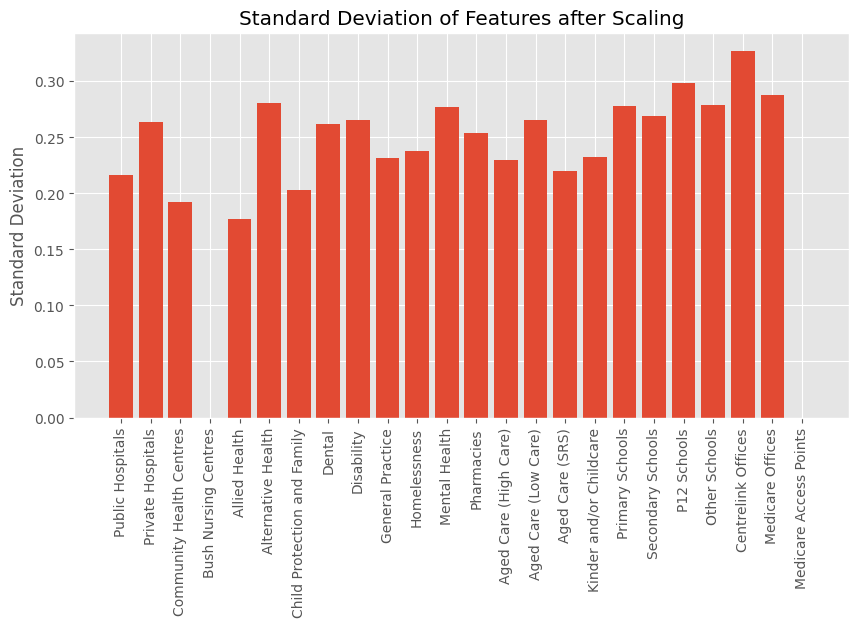

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
count,34.000000,34.000000,34.000000,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0
mean,0.066176,0.183824,0.102941,0.0,0.160208,0.237132,0.068627,0.239216,0.233032,0.232026,...,0.248739,0.110419,0.261765,0.387255,0.225490,0.186275,0.205882,0.117647,0.088235,0.0
std,0.215927,0.263347,0.192514,0.0,0.176910,0.280683,0.202887,0.261628,0.265448,0.231442,...,0.265606,0.219691,0.232268,0.277436,0.268687,0.298043,0.278460,0.327035,0.287902,0.0
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.0,0.064706,0.000000,0.000000,0.016667,0.019231,0.074074,...,0.000000,0.000000,0.100000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0,0.141176,0.125000,0.000000,0.133333,0.153846,0.185185,...,0.169643,0.000000,0.200000,0.333333,0.166667,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.000000,0.250000,0.166667,0.0,0.197059,0.406250,0.000000,0.400000,0.307692,0.287037,...,0.418750,0.165254,0.400000,0.500000,0.333333,0.333333,0.500000,0.000000,0.000000,0.0
max,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [66]:
# plot the standard deviation of the features
plt.figure(figsize=(10,5))
plt.bar(data_services_scaled.columns,data_services_scaled.std())
plt.xticks(rotation=90)
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Features after Scaling')
plt.show()
data_services_scaled.describe()

In [67]:
data_services_scaled['suburb_services_score']=data_services_scaled.mean(axis=1)
data_services_scaled.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points,suburb_services_score
0,0.00,0.25,0.166667,0.0,0.117647,0.3125,0.0,0.000000,0.000000,0.074074,...,0.000000,0.4,0.500000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.124661
1,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.076923,0.148148,...,0.000000,0.1,0.333333,0.666667,0.000000,0.5,0.0,0.0,0.0,0.107885
2,0.25,0.00,0.166667,0.0,0.176471,0.0000,0.0,0.066667,0.076923,0.296296,...,0.000000,0.2,1.000000,0.333333,0.333333,0.0,0.0,0.0,0.0,0.133961
3,0.00,0.25,0.000000,0.0,0.352941,0.5000,0.0,0.466667,0.692308,0.333333,...,0.381356,1.0,0.833333,0.666667,0.000000,0.0,0.0,0.0,0.0,0.318122
4,0.00,0.00,0.166667,0.0,0.152941,0.0625,0.0,0.066667,0.000000,0.185185,...,0.000000,0.3,0.666667,0.333333,0.333333,0.0,0.0,0.0,0.0,0.139885


<Figure size 1000x500 with 0 Axes>

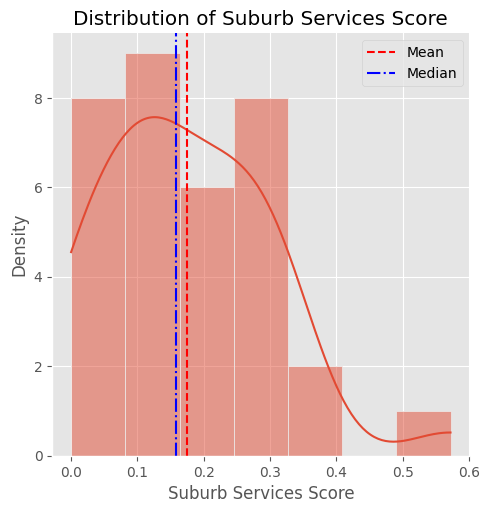

count    34.000000
mean      0.174807
std       0.127465
min       0.000000
25%       0.089691
50%       0.157910
75%       0.258785
max       0.572092
Name: suburb_services_score, dtype: float64

In [68]:
# plot the distribution of the suburb services score
plt.figure(figsize=(10,5))
sns.displot(data_services_scaled['suburb_services_score'],kde=True)
plt.title('Distribution of Suburb Services Score')
plt.xlabel('Suburb Services Score')
plt.ylabel('Density')
# show mean and median
plt.axvline(data_services_scaled['suburb_services_score'].mean(),color='red',label='Mean',linestyle='--')
plt.axvline(data_services_scaled['suburb_services_score'].median(),color='blue',label='Median',linestyle='-.')
plt.legend()
plt.show()
# describe the suburb services score
data_services_scaled['suburb_services_score'].describe()

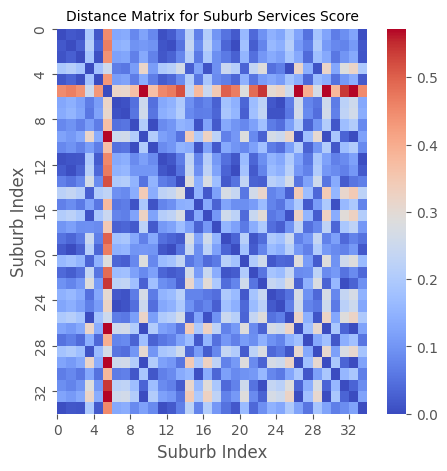

In [69]:
# define distance between two suburbs
# value is (absolute difference between the two suburb services scores)
def similarity_score(suburb1_idx,suburb2_idx):
	return np.abs(data_services_scaled['suburb_services_score'][suburb1_idx]-data_services_scaled['suburb_services_score'][suburb2_idx])

# calculate similarity matrix
distance_services=np.zeros((data_services_scaled.shape[0],data_services_scaled.shape[0]))
for i in range(data_services_scaled.shape[0]):
	for j in range(data_services_scaled.shape[0]):
		distance_services[i,j]=similarity_score(i,j)

# plot the similarity matrix
plt.figure(figsize=(5,5))
sns.heatmap(distance_services,cmap='coolwarm')
plt.title('Distance Matrix for Suburb Services Score',fontsize=10)
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
# tick every 4
plt.xticks(np.arange(0,data_services_scaled.shape[0],4),np.arange(0,data_services_scaled.shape[0],4))
plt.yticks(np.arange(0,data_services_scaled.shape[0],4),np.arange(0,data_services_scaled.shape[0],4))
plt.show()

Correlation between 2D distances and Services distances: 0.999500118075889
Procrustes Disparity between 2D distances and Services distances: 0.0006810474580765952
Stress of the MDS: 0.01049833971993749


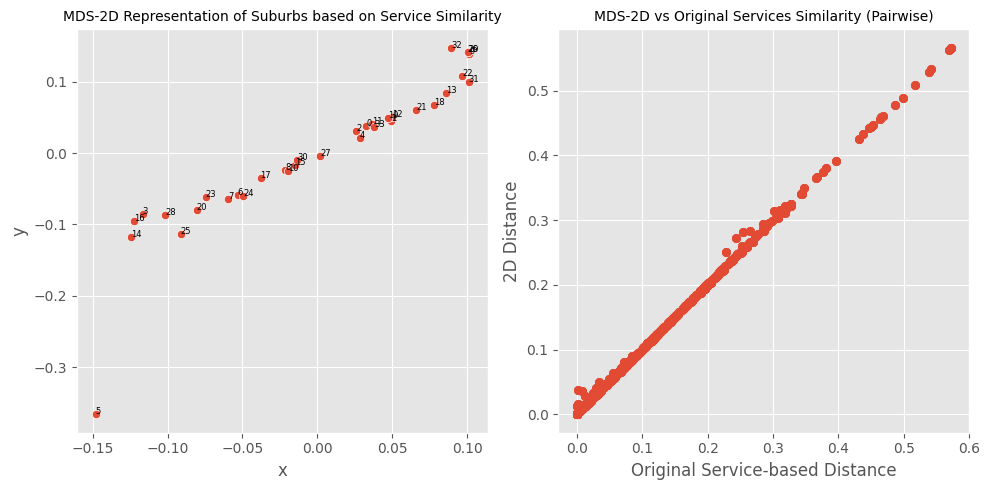

In [70]:
# Perform MDS on the similarity matrix to get the 2D representation of the suburbs
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
suburb_2d_services = mds.fit_transform(distance_services)
suburb_2d_services = pd.DataFrame(suburb_2d_services, columns=['x', 'y'])

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 2D representation of the suburbs in the first subplot
sns.scatterplot(x='x', y='y', data=suburb_2d_services, ax=axes[0])
axes[0].set_title("MDS-2D Representation of Suburbs based on Service Similarity", fontsize=10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Annotate the suburbs with the suburb index
for i in range(suburb_2d_services.shape[0]):
	axes[0].text(suburb_2d_services['x'].iloc[i], suburb_2d_services['y'].iloc[i], i, fontsize=6)

# Compute pairwise distances in the 2D representation
distances_2d_services = np.zeros((suburb_2d_services.shape[0], suburb_2d_services.shape[0]))
for i in range(suburb_2d_services.shape[0]):
	for j in range(suburb_2d_services.shape[0]):
		distances_2d_services[i, j] = np.sqrt(
			(suburb_2d_services['x'].iloc[i] - suburb_2d_services['x'].iloc[j])**2 +
			(suburb_2d_services['y'].iloc[i] - suburb_2d_services['y'].iloc[j])**2
		)

# Compute correlation between the pairwise distances in the 2D representation and the original distances
correlation = np.corrcoef(distance_services.flatten(), distances_2d_services.flatten())[0, 1]
print(f'Correlation between 2D distances and Services distances: {correlation}')

# Compute Procrustes analysis for the original and 2D representation
mtx1, mtx2, disparity = procrustes(distance_services, distances_2d_services)
print(f'Procrustes Disparity between 2D distances and Services distances: {disparity}')

# print the stress of the MDS
print(f'Stress of the MDS: {mds.stress_}')

# Plot the 2D distances vs original distances in the second subplot
axes[1].scatter(distance_services.flatten(), distances_2d_services.flatten())
axes[1].set_xlabel('Original Service-based Distance')
axes[1].set_ylabel('2D Distance')
axes[1].set_title('MDS-2D vs Original Services Similarity (Pairwise)', fontsize=10)

data['suburb_services_score']=data_services_scaled['suburb_services_score']

# Show the combined plot
plt.tight_layout()
plt.show()


In [71]:
# compute the correlation matrix for the two 2D representations
from scipy.spatial import procrustes

# Example distance matrices
matrix1 = distance_services
matrix2 = distance_original

# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(matrix1, matrix2)
print(f"Procrustes Disparity between Cartesian based distance matrix and Services based distance matrix: {disparity}")


Procrustes Disparity between Cartesian based distance matrix and Services based distance matrix: 0.8687077635866224


# Perspective 2: Land Use (percentage and amount)

In [72]:
feature='Land Use'
data_land=data[feature_category_dict[feature]]
data_land.head()

,Commercial (km^2),Commercial (%),Industrial (km^2),Industrial (%),Residential (km^2),Residential (%),Rural (km^2),Rural (%),Other (km^2),Other (%)
0,0.110250,2.874503,0.005093,0.132784,2.894001,75.454089,0.000000,0.000000,0.826102,21.538624
1,1.013147,23.425767,0.177854,4.112305,2.198204,50.826408,0.000000,0.000000,0.935720,21.635520
2,0.782388,2.215516,1.763098,4.992626,4.486082,12.703395,1.935031,5.479494,26.347439,74.608969
3,0.228507,1.609852,0.407614,2.871681,10.370552,73.061560,0.041521,0.292517,3.146073,22.164391
4,0.123132,2.421885,0.168014,3.304669,3.661186,72.011763,0.000000,0.000000,1.131817,22.261683


In [73]:
# only keep the columns with '%' symbol
data_land_percentage=data_land.loc[:,data_land.columns.str.contains('%')]
data_land_percentage.head()

,Commercial (%),Industrial (%),Residential (%),Rural (%),Other (%)
0,2.874503,0.132784,75.454089,0.000000,21.538624
1,23.425767,4.112305,50.826408,0.000000,21.635520
2,2.215516,4.992626,12.703395,5.479494,74.608969
3,1.609852,2.871681,73.061560,0.292517,22.164391
4,2.421885,3.304669,72.011763,0.000000,22.261683


In [74]:
# convert percentage to float
data_land_frac=data_land_percentage/100
for col in data_land_frac.columns:
	data_land_frac[col]=data_land_frac[col].astype(float)
	# change the column name
	data_land_frac.rename(columns={col:col.replace('%','frac')},inplace=True)

# print if all the rows sum to 1
all_rows_sum_to_1=True
for i in range(data_land_frac.shape[0]):
	if not np.isclose(data_land_frac.iloc[i].sum(),1):
		all_rows_sum_to_1=False
		print(f'Row {i} does not sum to 1')

if all_rows_sum_to_1:
	print('All rows sum to 1')

All rows sum to 1


[[0.         0.26385685 0.48493482 ... 0.43653836 0.24044731 0.15774871]
 [0.26385685 0.         0.45684808 ... 0.47888127 0.3571305  0.16209332]
 [0.48493482 0.45684808 0.         ... 0.41567217 0.33056845 0.51184925]
 ...
 [0.43653836 0.47888127 0.41567217 ... 0.         0.4150792  0.47354306]
 [0.24044731 0.3571305  0.33056845 ... 0.4150792  0.         0.32385086]
 [0.15774871 0.16209332 0.51184925 ... 0.47354306 0.32385086 0.        ]]


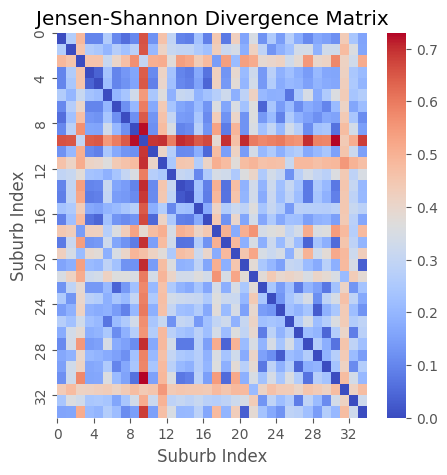

In [75]:
# compute the distance matrix in terms of Jensen-Shannon Divergence
distance_land_frac = np.zeros((data_land_frac.shape[0], data_land_frac.shape[0]))
for i in range(data_land_frac.shape[0]):
	for j in range(data_land_frac.shape[0]):
		distance_land_frac[i, j] = jensenshannon(data_land_frac.iloc[i], data_land_frac.iloc[j])

print(distance_land_frac)
# plot the distance matrix
plt.figure(figsize=(5,5))
sns.heatmap(distance_land_frac,cmap='coolwarm')
plt.title('Jensen-Shannon Divergence Matrix')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
# ticks every 4th
plt.xticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.yticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.show()

Correlation between 2D distances and Land Use Fraction distances: 0.9548464636903657
Procrustes Disparity between 2D distances and Land Use Fraction distances: 0.09372234824116418
Stress of the MDS: 1.668711805545386


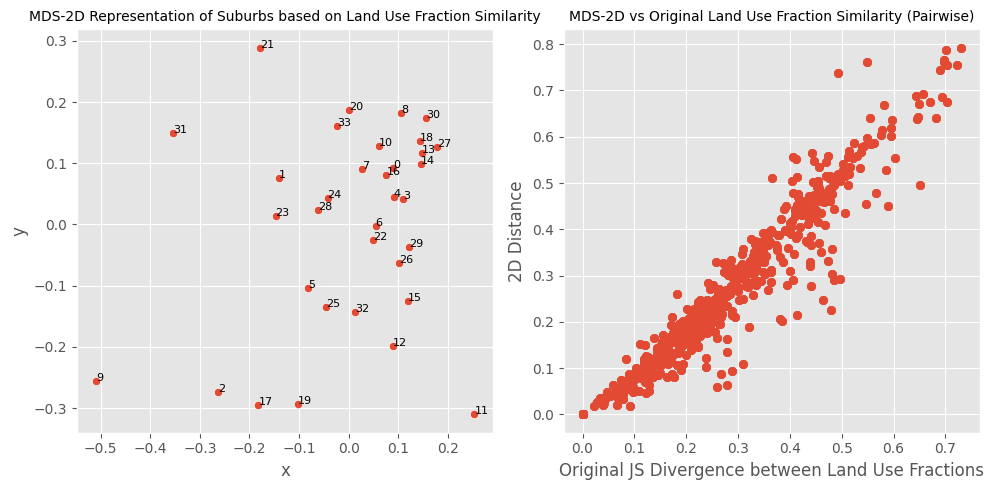

In [76]:
# Perform MDS on the similarity matrix to get the 2D representation of the suburbs
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
suburb_2d_land_frac = mds.fit_transform(distance_land_frac)
suburb_2d_land_frac = pd.DataFrame(suburb_2d_land_frac, columns=['x', 'y'])

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 2D representation of the suburbs in the first subplot
sns.scatterplot(x='x', y='y', data=suburb_2d_land_frac, ax=axes[0])
axes[0].set_title('MDS-2D Representation of Suburbs based on Land Use Fraction Similarity', fontsize=10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Annotate the suburbs with the suburb index
for i in range(suburb_2d_land_frac.shape[0]):
	axes[0].text(suburb_2d_land_frac['x'].iloc[i], suburb_2d_land_frac['y'].iloc[i], i, fontsize=8)

# Compute pairwise distances in the 2D representation
distances_2d_land_frac = np.zeros((suburb_2d_land_frac.shape[0], suburb_2d_land_frac.shape[0]))
for i in range(suburb_2d_land_frac.shape[0]):
	for j in range(suburb_2d_land_frac.shape[0]):
		distances_2d_land_frac[i, j] = np.sqrt(
			(suburb_2d_land_frac['x'].iloc[i] - suburb_2d_land_frac['x'].iloc[j])**2 + 
			(suburb_2d_land_frac['y'].iloc[i] - suburb_2d_land_frac['y'].iloc[j])**2
		)

# Compute correlation between the pairwise distances in the 2D representation and the original distances
correlation = np.corrcoef(distance_land_frac.flatten(), distances_2d_land_frac.flatten())[0, 1]
print(f'Correlation between 2D distances and Land Use Fraction distances: {correlation}')

# Compute Procrustes analysis for the original and 2D representation
mtx1, mtx2, disparity = procrustes(distance_land_frac, distances_2d_land_frac)
print(f'Procrustes Disparity between 2D distances and Land Use Fraction distances: {disparity}')

# print the stress of the MDS
print(f'Stress of the MDS: {mds.stress_}')

# Plot the 2D distances vs original distances in the second subplot
axes[1].scatter(distance_land_frac.flatten(), distances_2d_land_frac.flatten())
axes[1].set_xlabel('Original JS Divergence between Land Use Fractions')
axes[1].set_ylabel('2D Distance')
axes[1].set_title('MDS-2D vs Original Land Use Fraction Similarity (Pairwise)', fontsize=10)

# Show the combined plot
plt.tight_layout()
plt.show()


In [77]:
# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(distance_land_frac, distance_original)
print(f"Procrustes Disparity between Land Use based distance matrix and Cartesian based distance matrix: {disparity}")


Procrustes Disparity between Land Use based distance matrix and Cartesian based distance matrix: 0.8931504243896072


# Perspective 3: 2012 Population Age Distribution

In [78]:
feature='2012 population'
data_population=data[feature_category_dict[feature]]
# check for missing values
missing_values=data_population.isnull().sum()
print(f'Missing values in the data: {missing_values.sum()}')
data_population.head()

Missing values in the data: 0


,"2012 ERP age 0-4, persons","2012 ERP age 0-4, %","2012 ERP age 5-9, persons","2012 ERP age 5-9, %","2012 ERP age 10-14, persons","2012 ERP age 10-14, %","2012 ERP age 15-19, persons","2012 ERP age 15-19, %","2012 ERP age 20-24, persons","2012 ERP age 20-24, %",...,"2012 ERP age 65-69, %","2012 ERP age 70-74, persons","2012 ERP age 70-74, %","2012 ERP age 75-79, persons","2012 ERP age 75-79, %","2012 ERP age 80-84, persons","2012 ERP age 80-84, %","2012 ERP age 85+, persons","2012 ERP age 85+, %","2012 ERP, total"
0,1135,7.873196,804,5.577137,619,4.293840,575,3.988624,1229,8.525250,...,3.024417,344,2.386238,274,1.900666,234,1.623196,191,1.324917,14416
1,700,7.990868,562,6.415525,509,5.810502,598,6.826484,801,9.143836,...,2.625571,205,2.340183,189,2.157534,150,1.712329,109,1.244292,8760
2,3590,9.822430,2964,8.109661,2670,7.305261,2658,7.272429,2808,7.682837,...,1.991847,458,1.253112,277,0.757887,165,0.451449,72,0.196996,36549
3,1601,6.519526,1309,5.330456,1197,4.874374,1360,5.538136,1607,6.543959,...,4.996539,972,3.958138,798,3.249583,772,3.143706,790,3.217005,24557
4,950,7.134275,922,6.924001,815,6.120457,780,5.857615,869,6.525984,...,3.702313,574,4.310604,643,4.828777,569,4.273055,455,3.416942,13316


In [79]:
# select the columns with '%' symbol
data_population_percentage=data_population.loc[:,data_population.columns.str.contains('%')]
data_population_percentage.head()

,"2012 ERP age 0-4, %","2012 ERP age 5-9, %","2012 ERP age 10-14, %","2012 ERP age 15-19, %","2012 ERP age 20-24, %","2012 ERP age 25-44, %","2012 ERP age 45-64, %","2012 ERP age 65-69, %","2012 ERP age 70-74, %","2012 ERP age 75-79, %","2012 ERP age 80-84, %","2012 ERP age 85+, %"
0,7.873196,5.577137,4.293840,3.988624,8.525250,37.007492,22.475028,3.024417,2.386238,1.900666,1.623196,1.324917
1,7.990868,6.415525,5.810502,6.826484,9.143836,33.207763,20.525114,2.625571,2.340183,2.157534,1.712329,1.244292
2,9.822430,8.109661,7.305261,7.272429,7.682837,35.568689,19.587403,1.991847,1.253112,0.757887,0.451449,0.196996
3,6.519526,5.330456,4.874374,5.538136,6.543959,28.989697,23.638881,4.996539,3.958138,3.249583,3.143706,3.217005
4,7.134275,6.924001,6.120457,5.857615,6.525984,28.086512,18.819465,3.702313,4.310604,4.828777,4.273055,3.416942


In [80]:
# convert percentage to float
data_population_frac=data_population_percentage/100
for col in data_population_frac.columns:
	data_population_frac[col]=data_population_frac[col].astype(float)
	# change the column name
	data_population_frac.rename(columns={col:col.replace('%','frac')},inplace=True)

# print if all the rows sum to 1
all_rows_sum_to_1=True
for i in range(data_population_frac.shape[0]):
	if not np.isclose(data_population_frac.iloc[i].sum(),1):
		all_rows_sum_to_1=False
		print(f'Row {i} does not sum to 1')

if all_rows_sum_to_1:
	print('All rows sum to 1')
	

All rows sum to 1


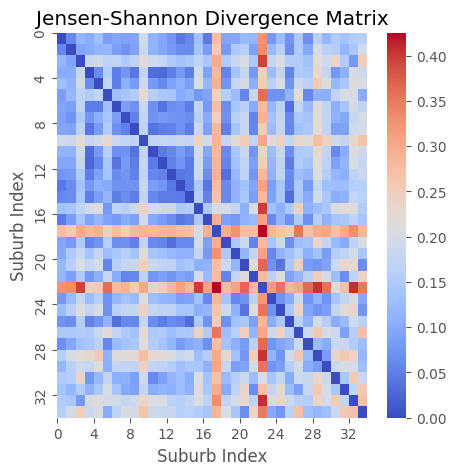

In [81]:
# compute the distance matrix in terms of Jensen-Shannon Divergence
distance_population_frac = np.zeros((data_population_frac.shape[0], data_population_frac.shape[0]))
for i in range(data_population_frac.shape[0]):
	for j in range(data_population_frac.shape[0]):
		distance_population_frac[i, j] = jensenshannon(data_population_frac.iloc[i], data_population_frac.iloc[j])

# plot the distance matrix
plt.figure(figsize=(5,5))
sns.heatmap(distance_population_frac,cmap='coolwarm')
plt.title('Jensen-Shannon Divergence Matrix')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
# ticks every 4th
plt.xticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.yticks(np.arange(0,data.shape[0],4), labels=np.arange(0,data.shape[0],4))
plt.show()

Correlation between 2D distances and Population Fraction distances: 0.940692895605369
Procrustes Disparity between 2D distances and Population Fraction distances: 0.11745265478578235
Stress of the MDS: 0.5746662941600144


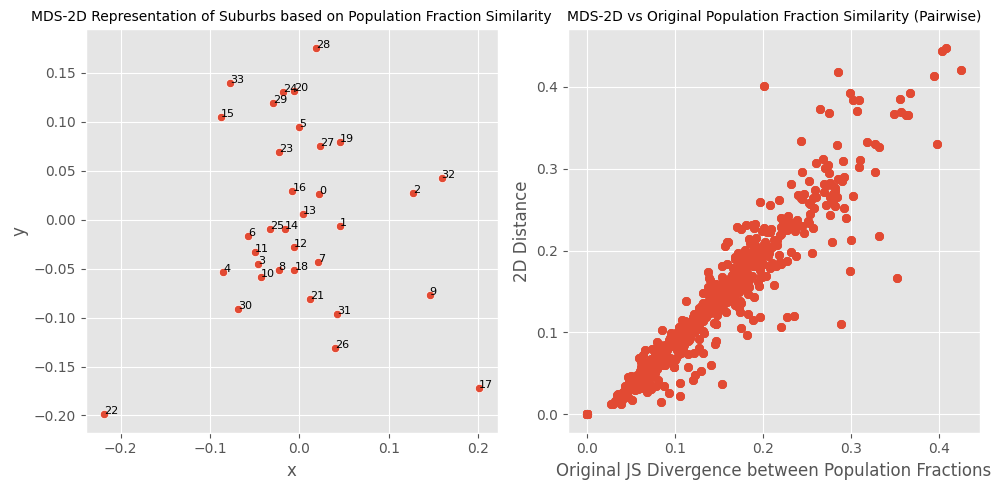

In [82]:
# Perform MDS on the similarity matrix to get the 2D representation of the suburbs
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
suburb_2d_population_frac = mds.fit_transform(distance_population_frac)
suburb_2d_population_frac = pd.DataFrame(suburb_2d_population_frac, columns=['x', 'y'])

# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the 2D representation of the suburbs in the first subplot
sns.scatterplot(x='x', y='y', data=suburb_2d_population_frac, ax=axes[0])
axes[0].set_title('MDS-2D Representation of Suburbs based on Population Fraction Similarity', fontsize=10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Annotate the suburbs with the suburb index
for i in range(suburb_2d_population_frac.shape[0]):
	axes[0].text(suburb_2d_population_frac['x'].iloc[i], suburb_2d_population_frac['y'].iloc[i], i, fontsize=8)

# Compute pairwise distances in the 2D representation
distances_2d_population_frac = np.zeros((suburb_2d_population_frac.shape[0], suburb_2d_population_frac.shape[0]))
for i in range(suburb_2d_population_frac.shape[0]):
	for j in range(suburb_2d_population_frac.shape[0]):
		distances_2d_population_frac[i, j] = np.sqrt(
			(suburb_2d_population_frac['x'].iloc[i] - suburb_2d_population_frac['x'].iloc[j])**2 +
			(suburb_2d_population_frac['y'].iloc[i] - suburb_2d_population_frac['y'].iloc[j])**2
		)

# Compute correlation between the pairwise distances in the 2D representation and the original distances
correlation = np.corrcoef(distance_population_frac.flatten(), distances_2d_population_frac.flatten())[0, 1]
print(f'Correlation between 2D distances and Population Fraction distances: {correlation}')

# Compute Procrustes analysis for the original and 2D representation
mtx1, mtx2, disparity = procrustes(distance_population_frac, distances_2d_population_frac)
print(f'Procrustes Disparity between 2D distances and Population Fraction distances: {disparity}')

# print the stress of the MDS
print(f'Stress of the MDS: {mds.stress_}')

# Plot the 2D distances vs original distances in the second subplot
axes[1].scatter(distance_population_frac.flatten(), distances_2d_population_frac.flatten())
axes[1].set_xlabel('Original JS Divergence between Population Fractions')
axes[1].set_ylabel('2D Distance')
axes[1].set_title('MDS-2D vs Original Population Fraction Similarity (Pairwise)', fontsize=10)

# Show the combined plot
plt.tight_layout()
plt.show()

In [83]:
# Apply Procrustes analysis
mtx1, mtx2, disparity = procrustes(distance_population_frac, distance_original)
print(f"Procrustes Disparity between Population Fraction based distance matrix and Cartesian based distance matrix: {disparity}")


Procrustes Disparity between Population Fraction based distance matrix and Cartesian based distance matrix: 0.7468839920301334


# A2: Post Metric Analysis

# Spectral Clustering Based on Metric-Specific Distances

## Spectral Clustering on Services

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import SpectralClustering

spectral_distance_services = np.exp(-distance_services)  # affinity matrix
spectral_distance_land_frac = np.exp(-distance_land_frac)
spectral_distance_population_frac = np.exp(-distance_population_frac)

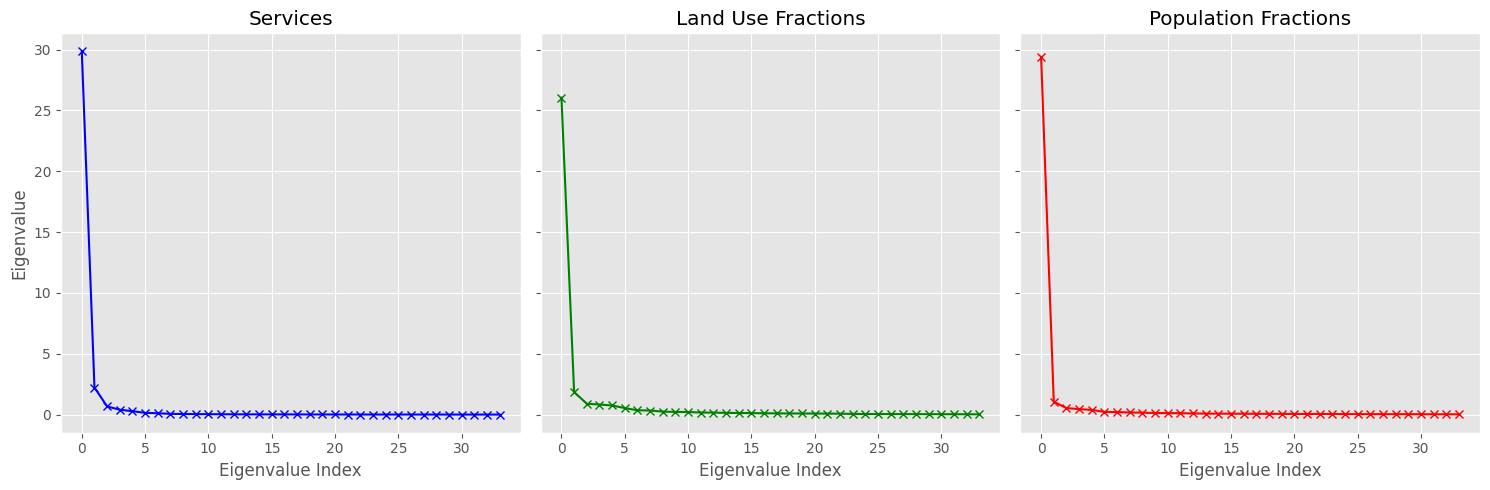

In [85]:
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Compute the eigenvalues and eigenvectors (assuming the spectral_distance_* matrices are defined)
eigenvalues_services, eigenvectors_services = eigh(spectral_distance_services)
eigenvalues_land_frac, eigenvectors_land_frac = eigh(spectral_distance_land_frac)
eigenvalues_population_frac, eigenvectors_population_frac = eigh(spectral_distance_population_frac)

# Create subplots in a single figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot eigenvalues for services
axes[0].plot(eigenvalues_services[::-1], label='Services', color='blue', marker='x')
axes[0].set_title('Services')
axes[0].set_xlabel('Eigenvalue Index')
axes[0].set_ylabel('Eigenvalue')

# Plot eigenvalues for land use fractions
axes[1].plot(eigenvalues_land_frac[::-1], label='Land Use Fractions', color='green', marker='x')
axes[1].set_title('Land Use Fractions')
axes[1].set_xlabel('Eigenvalue Index')

# Plot eigenvalues for population fractions
axes[2].plot(eigenvalues_population_frac[::-1], label='Population Fractions', color='red', marker='x')
axes[2].set_title('Population Fractions')
axes[2].set_xlabel('Eigenvalue Index')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### Elbow for all three at $k=3$

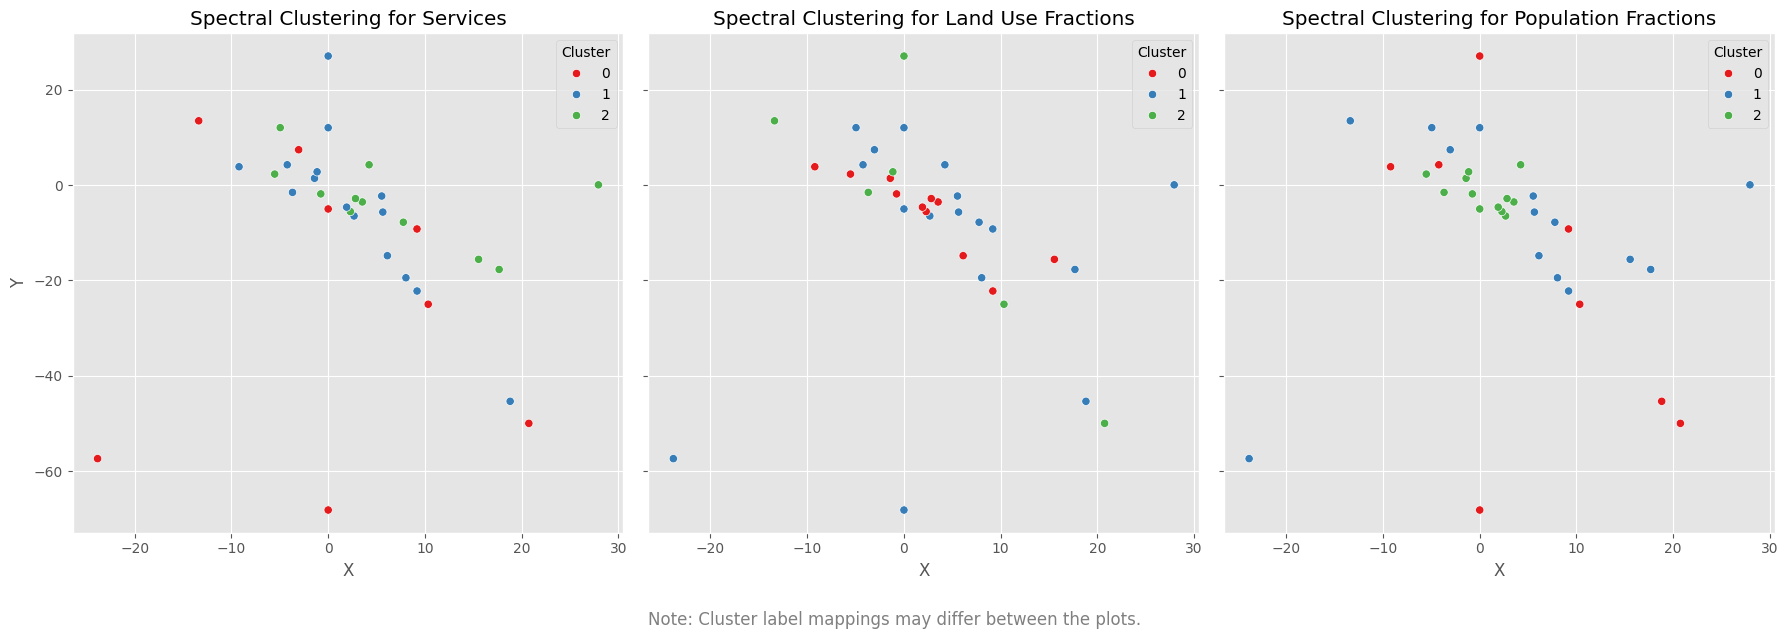

In [86]:
# Assuming 'data' and distance matrices (distance_services, distance_land_frac, distance_population_frac) are defined

# Spectral clustering for Services
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
spectral.fit(spectral_distance_services)
data['spectral_cluster_services'] = spectral.labels_

# Spectral clustering for Land Use Fractions
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
spectral.fit(spectral_distance_land_frac)
data['spectral_cluster_land_frac'] = spectral.labels_

# Spectral clustering for Population Fractions
spectral = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42)
spectral.fit(spectral_distance_population_frac)
data['spectral_cluster_population_frac'] = spectral.labels_

# Create subplots for the clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot clustering for Services
sns.scatterplot(
	ax=axes[0], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_services', palette='Set1'
)
axes[0].set_title('Spectral Clustering for Services')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend(title='Cluster', loc='upper right')

# Plot clustering for Land Use Fractions
sns.scatterplot(
	ax=axes[1], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_land_frac', palette='Set1'
)
axes[1].set_title('Spectral Clustering for Land Use Fractions')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].legend(title='Cluster', loc='upper right')

# Plot clustering for Population Fractions
sns.scatterplot(
	ax=axes[2], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_population_frac', palette='Set1'
)
axes[2].set_title('Spectral Clustering for Population Fractions')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].legend(title='Cluster', loc='upper right')

# Add a note at the bottom of the figure
fig.text(0.5, -0.05, 'Note: Cluster label mappings may differ between the plots.', 
		 ha='center', fontsize=12, color='gray')

# Adjust layout
plt.tight_layout()
plt.show()


### Hungarian Mapping for alignment

In [87]:
# Apply Hungarian algorithm to find the best label matching between the clusters

from scipy.optimize import linear_sum_assignment

# Define a function to find the best label matching
def find_best_label_matching(true_labels, predicted_labels):
	cost_matrix = np.zeros((len(np.unique(true_labels)), len(np.unique(predicted_labels))))
	
	for i, true_label in enumerate(np.unique(true_labels)):
		true_mask = true_labels == true_label
		for j, predicted_label in enumerate(np.unique(predicted_labels)):
			predicted_mask = predicted_labels == predicted_label
			cost_matrix[i, j] = np.sum(np.logical_and(true_mask, predicted_mask))
	
	row_ind, col_ind = linear_sum_assignment(-cost_matrix)
	return col_ind


# Find the best label matching for Services
label_matching_services = find_best_label_matching(data['spectral_cluster_services'], data['spectral_cluster_land_frac'])
data['spectral_cluster_services_matched'] = data['spectral_cluster_services'].map({i: j for i, j in enumerate(label_matching_services)})
data['spectral_cluster_services_matched'] = data['spectral_cluster_services_matched'].astype(int)

# Find the best label matching for Land Use Fractions
label_matching_land_frac = find_best_label_matching(data['spectral_cluster_land_frac'], data['spectral_cluster_services'])
data['spectral_cluster_land_frac_matched'] = data['spectral_cluster_land_frac'].map({i: j for i, j in enumerate(label_matching_land_frac)})
data['spectral_cluster_land_frac_matched'] = data['spectral_cluster_land_frac_matched'].astype(int)

# Find the best label matching for Population Fractions
label_matching_population_frac = find_best_label_matching(data['spectral_cluster_population_frac'], data['spectral_cluster_services'])
data['spectral_cluster_population_frac_matched'] = data['spectral_cluster_population_frac'].map({i: j for i, j in enumerate(label_matching_population_frac)})
data['spectral_cluster_population_frac_matched'] = data['spectral_cluster_population_frac_matched'].astype(int)

# print the best label matching
print('Best Label Matching for Services and Land Use Fractions:')
print(label_matching_services)
print('Best Label Matching for Land Use Fractions and Services:')
print(label_matching_land_frac)
print('Best Label Matching for Population Fractions and Services:')
print(label_matching_population_frac)

Best Label Matching for Services and Land Use Fractions:
[2 1 0]
Best Label Matching for Land Use Fractions and Services:
[2 1 0]
Best Label Matching for Population Fractions and Services:
[0 1 2]


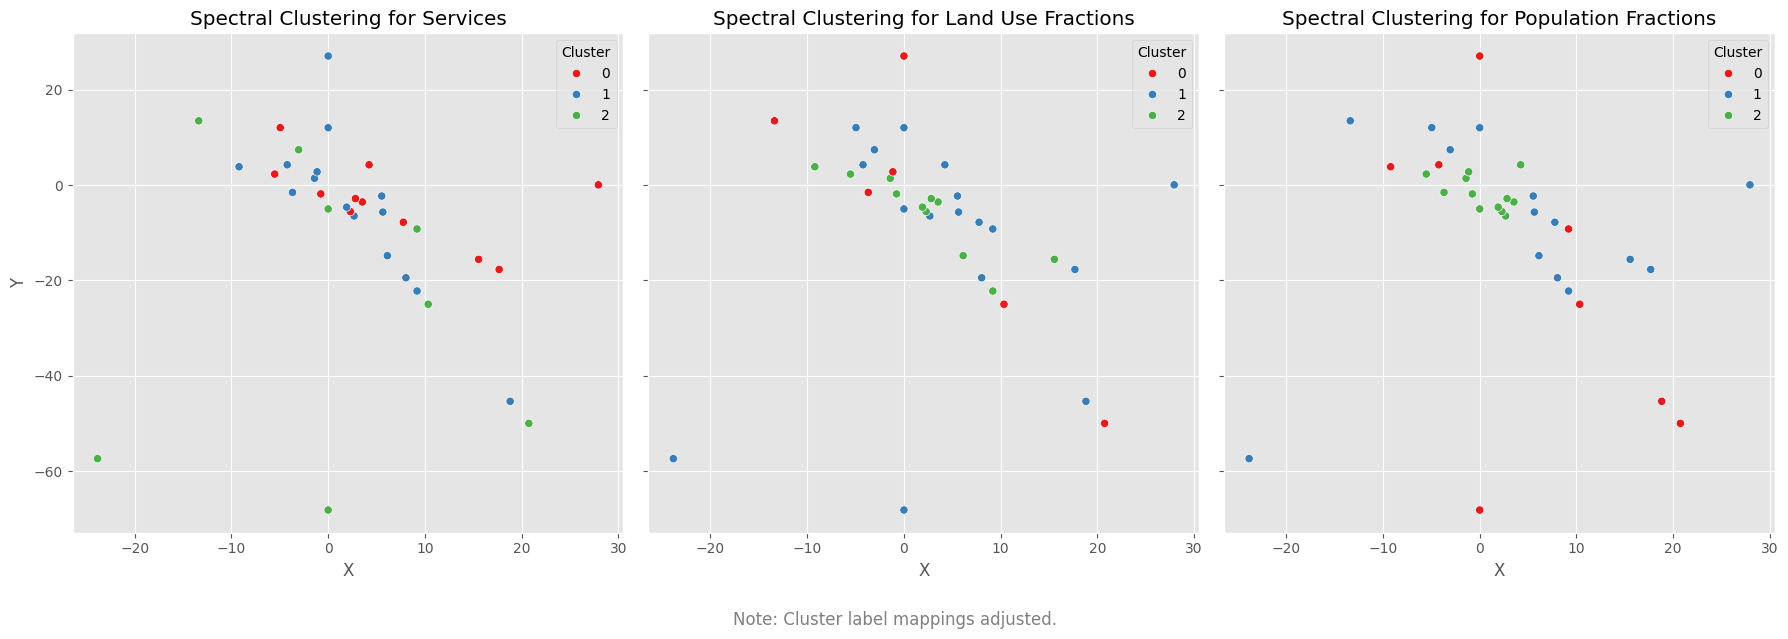

In [88]:
# re-plot the clustering results
# Create subplots for the clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot clustering for Services
sns.scatterplot(
	ax=axes[0], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_services_matched', palette='Set1'
)
axes[0].set_title('Spectral Clustering for Services')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend(title='Cluster', loc='upper right')

# Plot clustering for Land Use Fractions
sns.scatterplot(
	ax=axes[1], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_land_frac_matched', palette='Set1'
)
axes[1].set_title('Spectral Clustering for Land Use Fractions')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].legend(title='Cluster', loc='upper right')

# Plot clustering for Population Fractions
sns.scatterplot(
	ax=axes[2], x='cart_x', y='cart_y', data=data, hue='spectral_cluster_population_frac_matched', palette='Set1'
)
axes[2].set_title('Spectral Clustering for Population Fractions')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].legend(title='Cluster', loc='upper right')

# Add a note at the bottom of the figure
fig.text(0.5, -0.05, 'Note: Cluster label mappings adjusted.', 
		 ha='center', fontsize=12, color='gray')

plt.tight_layout()
plt.show()

In [89]:
# find the indices of the groupwise matches
matches_services_land_frac = np.where(data['spectral_cluster_services_matched'] == data['spectral_cluster_land_frac_matched'])[0]
matches_services_population_frac = np.where(data['spectral_cluster_services_matched'] == data['spectral_cluster_population_frac_matched'])[0]
matches_land_frac_population_frac = np.where(data['spectral_cluster_land_frac_matched'] == data['spectral_cluster_population_frac_matched'])[0]





# find the number of pairwise matches
num_matches_services_land_frac = np.sum(data['spectral_cluster_services_matched'] == data['spectral_cluster_land_frac_matched'])
num_matches_services_population_frac = np.sum(data['spectral_cluster_services_matched'] == data['spectral_cluster_population_frac_matched'])
num_matches_land_frac_population_frac = np.sum(data['spectral_cluster_land_frac_matched'] == data['spectral_cluster_population_frac_matched'])

# print the number of pairwise matches
print(f'Number of pairwise matches between Services and Land Use Fractions: {num_matches_services_land_frac}')
print(f'Number of pairwise matches between Services and Population Fractions: {num_matches_services_population_frac}')
print(f'Number of pairwise matches between Land Use Fractions and Population Fractions: {num_matches_land_frac_population_frac}')

# print the number of pairwise matches for each group
print(f'Index of pairwise matches for each group between Services and Land Use Fractions: {matches_services_land_frac}')
print(f'Index of pairwise matches for each group between Services and Population Fractions: {matches_services_population_frac}')
print(f'Index of pairwise matches for each group between Land Use Fractions and Population Fractions: {matches_land_frac_population_frac}')



########################

print('-----------------------------------')


# compute pairwise NMI between the clusters
from sklearn.metrics import normalized_mutual_info_score as NMI

nmi_services_land_frac = NMI(data['spectral_cluster_services_matched'], data['spectral_cluster_land_frac_matched'])
nmi_services_population_frac = NMI(data['spectral_cluster_services_matched'], data['spectral_cluster_population_frac_matched'])
nmi_land_frac_population_frac = NMI(data['spectral_cluster_land_frac_matched'], data['spectral_cluster_population_frac_matched'])

# compute ARIs
from sklearn.metrics import adjusted_rand_score as ARI

ari_services_land_frac = ARI(data['spectral_cluster_services_matched'], data['spectral_cluster_land_frac_matched'])
ari_services_population_frac = ARI(data['spectral_cluster_services_matched'], data['spectral_cluster_population_frac_matched'])
ari_land_frac_population_frac = ARI(data['spectral_cluster_land_frac_matched'], data['spectral_cluster_population_frac_matched'])

# print the pairwise NMI
print(f'Pairwise NMI between Services and Land Use Fractions: {nmi_services_land_frac}')
print(f'Pairwise NMI between Services and Population Fractions: {nmi_services_population_frac}')
print(f'Pairwise NMI between Land Use Fractions and Population Fractions: {nmi_land_frac_population_frac}')

# print the ARIs
print(f'ARI between Services and Land Use Fractions: {ari_services_land_frac}')
print(f'ARI between Services and Population Fractions: {ari_services_population_frac}')
print(f'ARI between Land Use Fractions and Population Fractions: {ari_land_frac_population_frac}')


Number of pairwise matches between Services and Land Use Fractions: 7
Number of pairwise matches between Services and Population Fractions: 7
Number of pairwise matches between Land Use Fractions and Population Fractions: 20
Index of pairwise matches for each group between Services and Land Use Fractions: [ 0  4  8 10 21 27 30]
Index of pairwise matches for each group between Services and Population Fractions: [ 4  8 10 11 12 29 30]
Index of pairwise matches for each group between Land Use Fractions and Population Fractions: [ 2  3  4  5  6  7  8 10 14 15 18 20 22 23 24 28 30 31 32 33]
-----------------------------------
Pairwise NMI between Services and Land Use Fractions: 0.17148272207000892
Pairwise NMI between Services and Population Fractions: 0.13314228249522692
Pairwise NMI between Land Use Fractions and Population Fractions: 0.13134356658392154
ARI between Services and Land Use Fractions: 0.02317903857136887
ARI between Services and Population Fractions: 0.024124329780303953
AR

In [90]:
# compute pairwise procrustes disparity
disparity_metrics_pairs = np.zeros((3, 3))
dist_metrics=[distance_services,distance_land_frac,distance_population_frac]
for i in range(3):
	for j in range(3):
		_, _, disparity_metrics_pairs[i, j] = procrustes(dist_metrics[i], dist_metrics[j])


# print the pairwise procrustes disparity
print('Pairwise Procrustes Disparity:')
print(np.round(disparity_metrics_pairs, 5))
# print the mapping dictionary for the metrics
print('\n')
print('Mapping Dictionary:')
print({
	0: 'Services',
	1: 'Land Use Fractions',
	2: 'Population Fractions'
})


Pairwise Procrustes Disparity:
[[0.      0.87008 0.89249]
 [0.87008 0.      0.79728]
 [0.89249 0.79728 0.     ]]


Mapping Dictionary:
{0: 'Services', 1: 'Land Use Fractions', 2: 'Population Fractions'}


# Tobler's Law

## Services Score

In [91]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from esda import Moran, Geary, G_Local
import matplotlib.pyplot as plt

# the data is already loaded
# (x, y) coordinates of the suburbs are in the columns 'cart_x' and 'cart_y'

# use KNN weights with k=3
gdf=gpd.GeoDataFrame(data,geometry=gpd.points_from_xy(data['cart_x'],data['cart_y']))
w=weights.KNN.from_dataframe(gdf,k=3)

# calculate Moran's I
moran = Moran(data['suburb_services_score'], w)
print(f'Moran\'s I for Services Score: {moran.I:.5f}')
print(f'Moran\'s I p-value: {moran.p_sim:.5f}')

# calculate Geary's C
geary = Geary(data['suburb_services_score'], w)
print(f'Geary\'s C for Services Score: {geary.C:.5f}')
print(f'Geary\'s C p-value: {geary.p_sim:.5f}')




Moran's I for Services Score: 0.07693
Moran's I p-value: 0.17600
Geary's C for Services Score: 0.89013
Geary's C p-value: 0.22400


c:\Users\subha\miniconda3\Lib\site-packages\esda\moran.py:254: RuntimeWarning: invalid value encountered in scalar divide
  k = k_num / k_den
c:\Users\subha\miniconda3\Lib\site-packages\esda\moran.py:266: RuntimeWarning: invalid value encountered in scalar divide
  return self.n / s0 * inum / self.z2ss
c:\Users\subha\miniconda3\Lib\site-packages\esda\moran.py:223: RuntimeWarning: invalid value encountered in divide
  self.z /= sy
c:\Users\subha\miniconda3\Lib\site-packages\esda\geary.py:177: RuntimeWarning: invalid value encountered in scalar divide
  k = (yd4.sum() / n) / ((yd2.sum() / n) ** 2)
c:\Users\subha\miniconda3\Lib\site-packages\esda\geary.py:192: RuntimeWarning: invalid value encountered in scalar divide
  return a / self.den


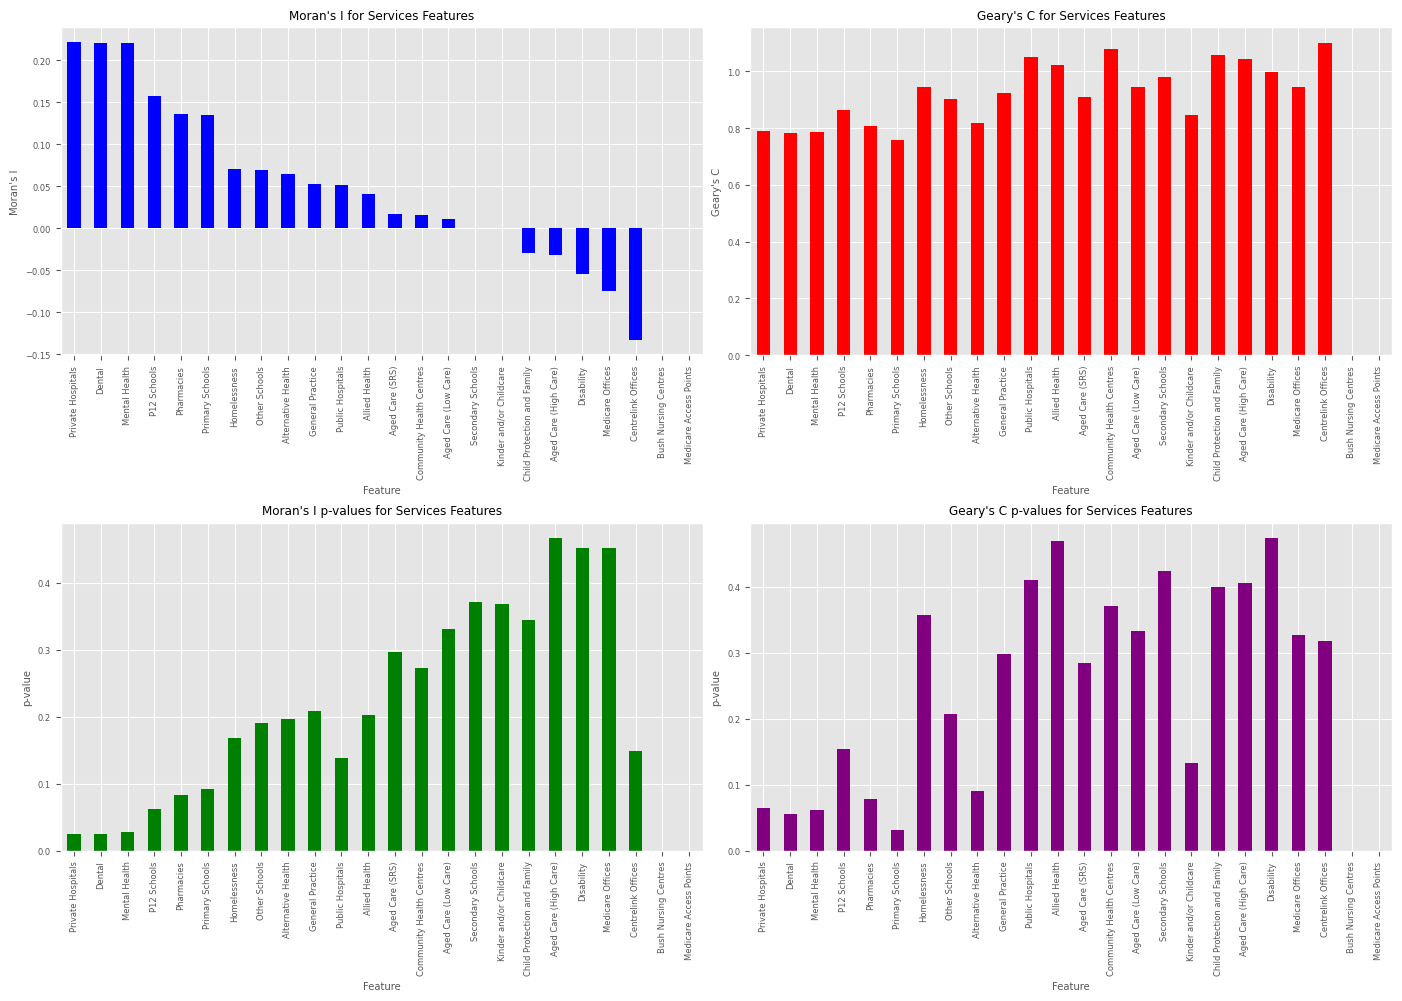

Number of significant Moran's I: 5
Number of significant Geary's C: 3
Features with significant Moran's I:
Index(['Private Hospitals', 'Dental', 'Mental Health', 'Bush Nursing Centres',
       'Medicare Access Points'],
      dtype='object')


Features with significant Geary's C:
Index(['Primary Schools', 'Bush Nursing Centres', 'Medicare Access Points'], dtype='object')


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from esda import Moran, Geary
from pysal.lib import weights

# Assume 'data', 'feature_category_dict', and spatial weights 'w' are already defined

# Set global font size for all elements
plt.rcParams.update({'font.size': 6})

# Any plot created after this will use the updated font size


# Compute Moran's I and Geary's C for each feature in 'Services'
moran_results = {}
geary_results = {}
moran_p_values = {}
geary_p_values = {}

for feature in feature_category_dict['Services']:
	moran = Moran(data[feature], w, permutations=9999)
	geary = Geary(data[feature], w, permutations=9999)
	moran_results[feature] = moran.I
	geary_results[feature] = geary.C
	moran_p_values[feature] = moran.p_sim
	geary_p_values[feature] = geary.p_sim

# Create a DataFrame for Moran's I, Geary's C, and their p-values
moran_geary_df = pd.DataFrame({
	"Moran's I": moran_results,
	"Geary's C": geary_results,
	"Moran's I p-value": moran_p_values,
	"Geary's C p-value": geary_p_values
})
moran_geary_df = moran_geary_df.sort_values(by="Moran's I", ascending=False)

# Plot Moran's I, Geary's C, and their p-values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Moran's I
moran_geary_df["Moran's I"].plot(kind='bar', ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Moran's I for Services Features")
axes[0, 0].set_ylabel("Moran's I")
axes[0, 0].set_xlabel("Feature")
axes[0, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C
moran_geary_df["Geary's C"].plot(kind='bar', ax=axes[0, 1], color='red')
axes[0, 1].set_title("Geary's C for Services Features")
axes[0, 1].set_ylabel("Geary's C")
axes[0, 1].set_xlabel("Feature")
axes[0, 1].tick_params(axis='x', rotation=90)

# Plot Moran's I p-values
moran_geary_df["Moran's I p-value"].plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title("Moran's I p-values for Services Features")
axes[1, 0].set_ylabel("p-value")
axes[1, 0].set_xlabel("Feature")
axes[1, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C p-values
moran_geary_df["Geary's C p-value"].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title("Geary's C p-values for Services Features")
axes[1, 1].set_ylabel("p-value")
axes[1, 1].set_xlabel("Feature")
axes[1, 1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

# count number of significant Moran's I and Geary's C
significant_moran = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].shape[0]
significant_geary = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].shape[0]

# print the number of significant Moran's I and Geary's C
print(f'Number of significant Moran\'s I: {significant_moran}')
print(f'Number of significant Geary\'s C: {significant_geary}')

# print the names of the features with significant Moran's I and Geary's C
significant_moran_features = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].index
significant_geary_features = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].index

print('Features with significant Moran\'s I:')
print(significant_moran_features)
print('\n')
print('Features with significant Geary\'s C:')
print(significant_geary_features)


In [93]:
# print the significant Moran's I and Geary's C values
significant_moran_values, significant_moran_p_values = moran_geary_df.loc[significant_moran_features, "Moran's I"], moran_geary_df.loc[significant_moran_features, "Moran's I p-value"]
significant_geary_values, significant_geary_p_values = moran_geary_df.loc[significant_geary_features, "Geary's C"], moran_geary_df.loc[significant_geary_features, "Geary's C p-value"]

print('Significant Moran\'s I values:')
print(significant_moran_values)
print('\n')
print('Significant Moran\'s I p-values:')
print(significant_moran_p_values)
print('-----------------------------------')
print('Significant Geary\'s C values:')
print(significant_geary_values)
print('\n')
print('Significant Geary\'s C p-values:')
print(significant_geary_p_values)


Significant Moran's I values:
Private Hospitals         0.221151
Dental                    0.220756
Mental Health             0.219721
Bush Nursing Centres           NaN
Medicare Access Points         NaN
Name: Moran's I, dtype: float64


Significant Moran's I p-values:
Private Hospitals         0.0248
Dental                    0.0249
Mental Health             0.0279
Bush Nursing Centres      0.0001
Medicare Access Points    0.0001
Name: Moran's I p-value, dtype: float64
-----------------------------------
Significant Geary's C values:
Primary Schools           0.757157
Bush Nursing Centres           NaN
Medicare Access Points         NaN
Name: Geary's C, dtype: float64


Significant Geary's C p-values:
Primary Schools           0.0320
Bush Nursing Centres      0.0001
Medicare Access Points    0.0001
Name: Geary's C p-value, dtype: float64


In [94]:
# compute fraction of significant Moran's I and Geary's C
fraction_significant_moran = significant_moran / len(moran_geary_df)
fraction_significant_geary = significant_geary / len(moran_geary_df)

# print the fraction of significant Moran's I and Geary's C
print(f'Fraction of significant Moran\'s I: {fraction_significant_moran:.2f}')
print(f'Fraction of significant Geary\'s C: {fraction_significant_geary:.2f}')

Fraction of significant Moran's I: 0.21
Fraction of significant Geary's C: 0.12


In [95]:
data['suburb_services_score']

0     0.124661
1     0.107885
2     0.133961
3     0.318122
4     0.139885
5     0.572092
6     0.252973
7     0.260722
8     0.205406
9     0.002033
10    0.205509
11    0.119416
12    0.103916
13    0.054420
14    0.344666
15    0.195885
16    0.328069
17    0.224979
18    0.072486
19    0.105986
20    0.286568
21    0.084949
22    0.029805
23    0.269931
24    0.250771
25    0.319657
26    0.000000
27    0.175935
28    0.307175
29    0.000000
30    0.190182
31    0.033488
32    0.000000
33    0.121916
Name: suburb_services_score, dtype: float64

In [96]:
# weight of the 'services_score' contributed by significant Moran's I and Geary's C
significant_moran_weight = data_services_scaled[significant_moran_features].sum().sum() / (data['suburb_services_score'].sum()*data_services_scaled.shape[1])
significant_geary_weight = data_services_scaled[significant_geary_features].sum().sum() / (data['suburb_services_score'].sum()*data_services_scaled.shape[1])

# print the % weight of the 'services_score' contributed by significant Moran's I and Geary's C
print(f'Weight of significant Moran\'s I in Service Score: {significant_moran_weight:.2%}')
print(f'Weight of significant Geary\'s C in Service Score: {significant_geary_weight:.2%}')

Weight of significant Moran's I in Service Score: 15.25%
Weight of significant Geary's C in Service Score: 8.86%


## Land Use

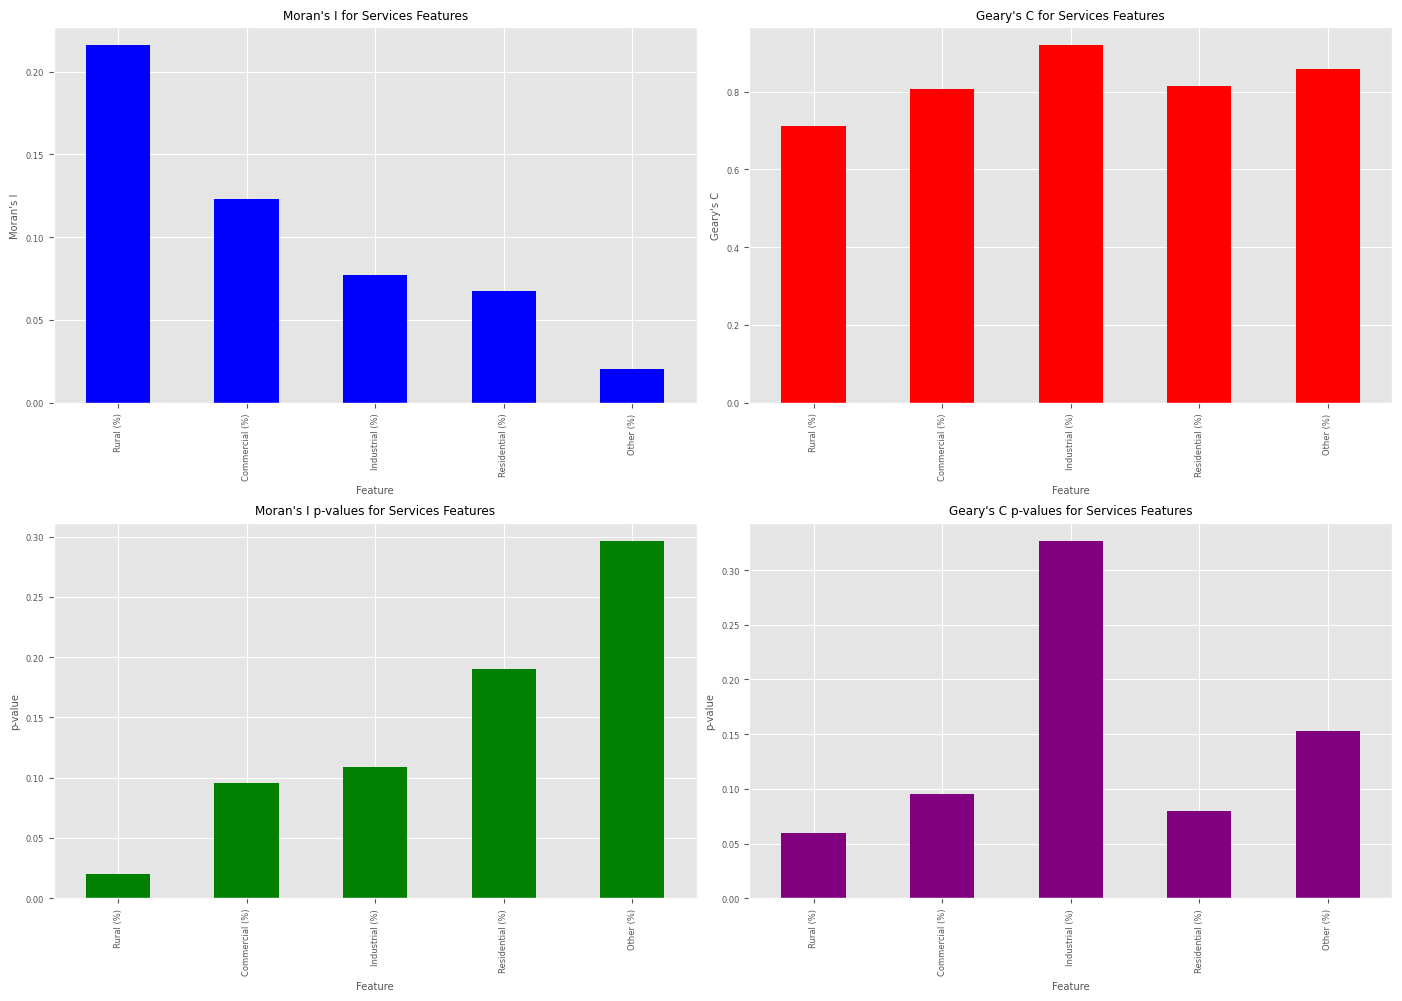

Number of significant Moran's I: 1
Number of significant Geary's C: 0
Features with significant Moran's I:
Index(['Rural (%)'], dtype='object')


Features with significant Geary's C:
Index([], dtype='object')


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from esda import Moran, Geary
from pysal.lib import weights

# Assume 'data', 'feature_category_dict', and spatial weights 'w' are already defined

# Set global font size for all elements
plt.rcParams.update({'font.size': 6})

# Any plot created after this will use the updated font size


# Compute Moran's I and Geary's C for each feature in 'Services'
moran_results = {}
geary_results = {}
moran_p_values = {}
geary_p_values = {}

land_use_frac_features = data_land_percentage.columns

for feature in land_use_frac_features:
	moran = Moran(data[feature], w, permutations=9999)
	geary = Geary(data[feature], w, permutations=9999)
	moran_results[feature] = moran.I
	geary_results[feature] = geary.C
	moran_p_values[feature] = moran.p_sim
	geary_p_values[feature] = geary.p_sim

# Create a DataFrame for Moran's I, Geary's C, and their p-values
moran_geary_df = pd.DataFrame({
	"Moran's I": moran_results,
	"Geary's C": geary_results,
	"Moran's I p-value": moran_p_values,
	"Geary's C p-value": geary_p_values
})
moran_geary_df = moran_geary_df.sort_values(by="Moran's I", ascending=False)

# Plot Moran's I, Geary's C, and their p-values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Moran's I
moran_geary_df["Moran's I"].plot(kind='bar', ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Moran's I for Services Features")
axes[0, 0].set_ylabel("Moran's I")
axes[0, 0].set_xlabel("Feature")
axes[0, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C
moran_geary_df["Geary's C"].plot(kind='bar', ax=axes[0, 1], color='red')
axes[0, 1].set_title("Geary's C for Services Features")
axes[0, 1].set_ylabel("Geary's C")
axes[0, 1].set_xlabel("Feature")
axes[0, 1].tick_params(axis='x', rotation=90)

# Plot Moran's I p-values
moran_geary_df["Moran's I p-value"].plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title("Moran's I p-values for Services Features")
axes[1, 0].set_ylabel("p-value")
axes[1, 0].set_xlabel("Feature")
axes[1, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C p-values
moran_geary_df["Geary's C p-value"].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title("Geary's C p-values for Services Features")
axes[1, 1].set_ylabel("p-value")
axes[1, 1].set_xlabel("Feature")
axes[1, 1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

# count number of significant Moran's I and Geary's C
significant_moran = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].shape[0]
significant_geary = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].shape[0]

# print the number of significant Moran's I and Geary's C
print(f'Number of significant Moran\'s I: {significant_moran}')
print(f'Number of significant Geary\'s C: {significant_geary}')

# print the names of the features with significant Moran's I and Geary's C
significant_moran_features = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].index
significant_geary_features = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].index

print('Features with significant Moran\'s I:')
print(significant_moran_features)
print('\n')
print('Features with significant Geary\'s C:')
print(significant_geary_features)


In [98]:
# print the significant Moran's I and Geary's C values
significant_moran_values, significant_moran_p_values = moran_geary_df.loc[significant_moran_features, "Moran's I"], moran_geary_df.loc[significant_moran_features, "Moran's I p-value"]
significant_geary_values, significant_geary_p_values = moran_geary_df.loc[significant_geary_features, "Geary's C"], moran_geary_df.loc[significant_geary_features, "Geary's C p-value"]

print('Significant Moran\'s I values:')
print(significant_moran_values)
print('\n')
print('Significant Moran\'s I p-values:')
print(significant_moran_p_values)
print('-----------------------------------')
print('Significant Geary\'s C values:')
print(significant_geary_values)
print('\n')
print('Significant Geary\'s C p-values:')
print(significant_geary_p_values)

Significant Moran's I values:
Rural (%)    0.215899
Name: Moran's I, dtype: float64


Significant Moran's I p-values:
Rural (%)    0.0197
Name: Moran's I p-value, dtype: float64
-----------------------------------
Significant Geary's C values:
Series([], Name: Geary's C, dtype: float64)


Significant Geary's C p-values:
Series([], Name: Geary's C p-value, dtype: float64)


In [99]:
# compute fraction of significant Moran's I and Geary's C
fraction_significant_moran = significant_moran / len(moran_geary_df)
fraction_significant_geary = significant_geary / len(moran_geary_df)

# print the fraction of significant Moran's I and Geary's C
print(f'Fraction of significant Moran\'s I: {fraction_significant_moran:.2f}')
print(f'Fraction of significant Geary\'s C: {fraction_significant_geary:.2f}')


Fraction of significant Moran's I: 0.20
Fraction of significant Geary's C: 0.00


In [100]:
# weight of the 'Land Use Fractions' contributed by significant Moran's I and Geary's C
significant_moran_weight = data_land_percentage[significant_moran_features].sum().sum() / data_land_percentage.sum().sum()
significant_geary_weight = data_land_percentage[significant_geary_features].sum().sum() / data_land_percentage.sum().sum()

# print the % weight of the 'Land Use Fractions' contributed by significant Moran's I and Geary's C
print(f'Weight of significant Moran\'s I in Land Use Fractions: {significant_moran_weight:.2%}')
print(f'Weight of significant Geary\'s C in Land Use Fractions: {significant_geary_weight:.2%}')


Weight of significant Moran's I in Land Use Fractions: 2.84%
Weight of significant Geary's C in Land Use Fractions: 0.00%


### Population Distribution

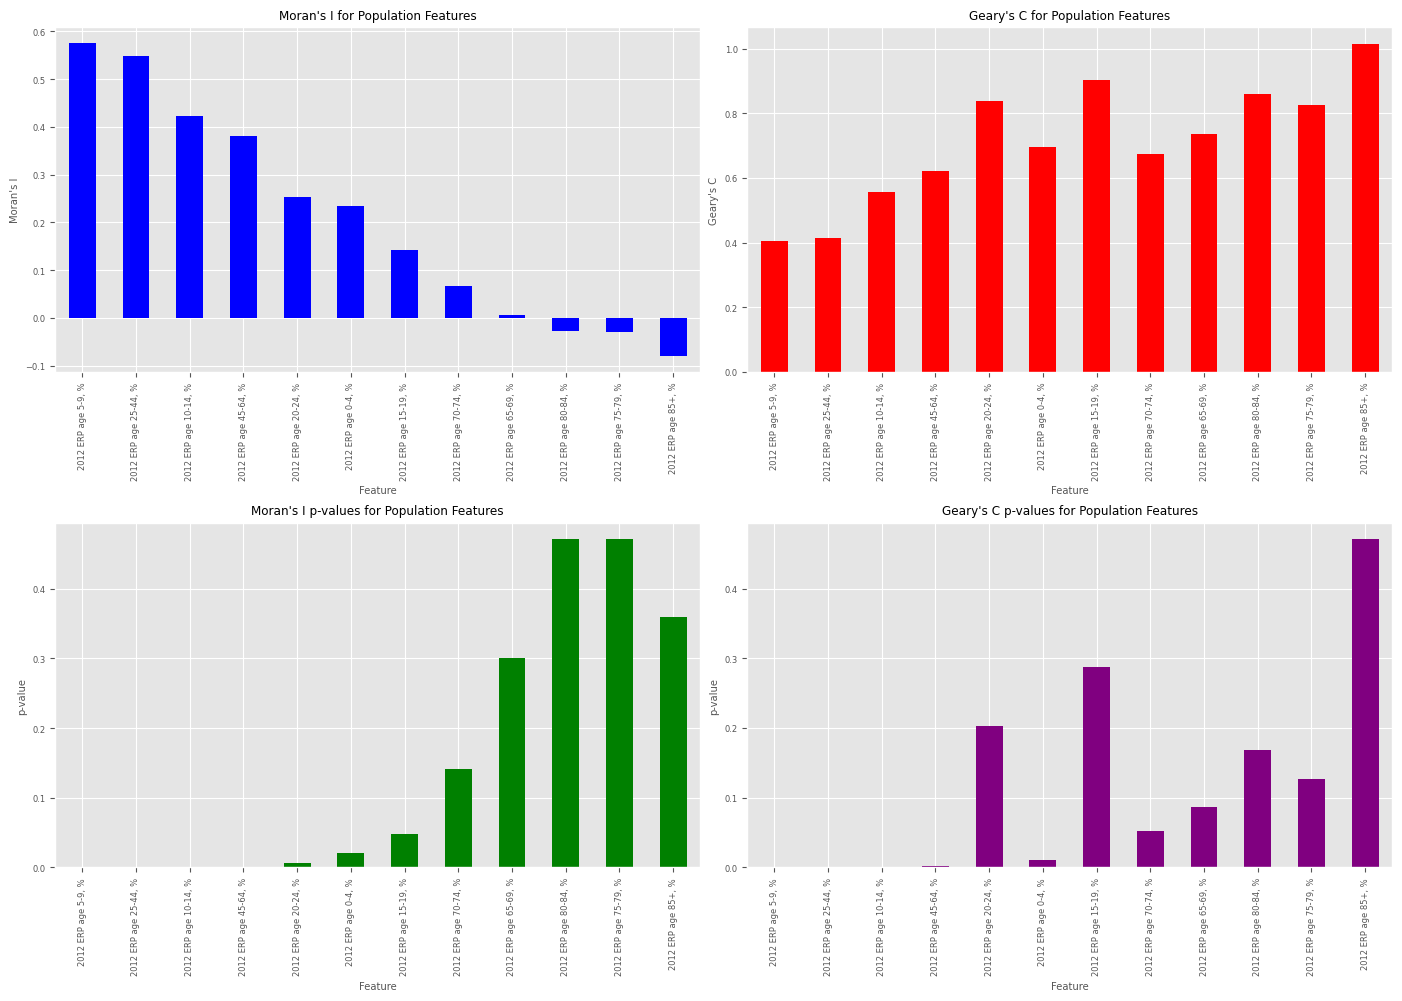

In [101]:
# compute Moran's I and Geary's C for each feature in 'Population'
moran_results = {}
geary_results = {}
moran_p_values = {}
geary_p_values = {}

population_frac_features = data_population_percentage.columns

for feature in population_frac_features:
	moran = Moran(data[feature], w, permutations=9999)
	geary = Geary(data[feature], w, permutations=9999)
	moran_results[feature] = moran.I
	geary_results[feature] = geary.C
	moran_p_values[feature] = moran.p_sim
	geary_p_values[feature] = geary.p_sim
	
# Create a DataFrame for Moran's I, Geary's C, and their p-values
moran_geary_df = pd.DataFrame({
	"Moran's I": moran_results,
	"Geary's C": geary_results,
	"Moran's I p-value": moran_p_values,
	"Geary's C p-value": geary_p_values
})

moran_geary_df = moran_geary_df.sort_values(by="Moran's I", ascending=False)

# Plot Moran's I, Geary's C, and their p-values
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Moran's I
moran_geary_df["Moran's I"].plot(kind='bar', ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Moran's I for Population Features")
axes[0, 0].set_ylabel("Moran's I")
axes[0, 0].set_xlabel("Feature")
axes[0, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C
moran_geary_df["Geary's C"].plot(kind='bar', ax=axes[0, 1], color='red')
axes[0, 1].set_title("Geary's C for Population Features")
axes[0, 1].set_ylabel("Geary's C")
axes[0, 1].set_xlabel("Feature")
axes[0, 1].tick_params(axis='x', rotation=90)

# Plot Moran's I p-values
moran_geary_df["Moran's I p-value"].plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title("Moran's I p-values for Population Features")
axes[1, 0].set_ylabel("p-value")
axes[1, 0].set_xlabel("Feature")
axes[1, 0].tick_params(axis='x', rotation=90)

# Plot Geary's C p-values
moran_geary_df["Geary's C p-value"].plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title("Geary's C p-values for Population Features")
axes[1, 1].set_ylabel("p-value")
axes[1, 1].set_xlabel("Feature")
axes[1, 1].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()

In [102]:
# count number of significant Moran's I and Geary's C
significant_moran = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].shape[0]
significant_geary = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].shape[0]

# print the number of significant Moran's I and Geary's C
print(f'Number of significant Moran\'s I: {significant_moran}')
print(f'Number of significant Geary\'s C: {significant_geary}')

Number of significant Moran's I: 7
Number of significant Geary's C: 5


In [103]:
# print the names of the features with significant Moran's I and Geary's C
significant_moran_features = moran_geary_df[moran_geary_df["Moran's I p-value"] < 0.05].index
significant_geary_features = moran_geary_df[moran_geary_df["Geary's C p-value"] < 0.05].index

print('Features with significant Moran\'s I:')
print(significant_moran_features)
print('\n')
print('Features with significant Geary\'s C:')
print(significant_geary_features)


Features with significant Moran's I:
Index(['2012 ERP age 5-9, %', '2012 ERP age 25-44, %', '2012 ERP age 10-14, %',
       '2012 ERP age 45-64, %', '2012 ERP age 20-24, %', '2012 ERP age 0-4, %',
       '2012 ERP age 15-19, %'],
      dtype='object')


Features with significant Geary's C:
Index(['2012 ERP age 5-9, %', '2012 ERP age 25-44, %', '2012 ERP age 10-14, %',
       '2012 ERP age 45-64, %', '2012 ERP age 0-4, %'],
      dtype='object')


In [104]:
# print the significant Moran's I and Geary's C values
significant_moran_values, significant_moran_p_values = moran_geary_df.loc[significant_moran_features, "Moran's I"], moran_geary_df.loc[significant_moran_features, "Moran's I p-value"]
significant_geary_values, significant_geary_p_values = moran_geary_df.loc[significant_geary_features, "Geary's C"], moran_geary_df.loc[significant_geary_features, "Geary's C p-value"]

print('Significant Moran\'s I values:')
print(significant_moran_values)
print('\n')
print('Significant Moran\'s I p-values:')
print(significant_moran_p_values)
print('-----------------------------------')
print('Significant Geary\'s C values:')
print(significant_geary_values)
print('\n')
print('Significant Geary\'s C p-values:')
print(significant_geary_p_values)

# compute fraction of significant Moran's I and Geary's C
fraction_significant_moran = significant_moran / len(moran_geary_df)
fraction_significant_geary = significant_geary / len(moran_geary_df)

# print the fraction of significant Moran's I and Geary's C
print(f'Fraction of significant Moran\'s I: {fraction_significant_moran:.2f}')
print(f'Fraction of significant Geary\'s C: {fraction_significant_geary:.2f}')


Significant Moran's I values:
2012 ERP age 5-9, %      0.575397
2012 ERP age 25-44, %    0.548894
2012 ERP age 10-14, %    0.423003
2012 ERP age 45-64, %    0.380905
2012 ERP age 20-24, %    0.253615
2012 ERP age 0-4, %      0.234849
2012 ERP age 15-19, %    0.142613
Name: Moran's I, dtype: float64


Significant Moran's I p-values:
2012 ERP age 5-9, %      0.0001
2012 ERP age 25-44, %    0.0001
2012 ERP age 10-14, %    0.0003
2012 ERP age 45-64, %    0.0010
2012 ERP age 20-24, %    0.0058
2012 ERP age 0-4, %      0.0206
2012 ERP age 15-19, %    0.0485
Name: Moran's I p-value, dtype: float64
-----------------------------------
Significant Geary's C values:
2012 ERP age 5-9, %      0.405475
2012 ERP age 25-44, %    0.415260
2012 ERP age 10-14, %    0.556916
2012 ERP age 45-64, %    0.619858
2012 ERP age 0-4, %      0.695853
Name: Geary's C, dtype: float64


Significant Geary's C p-values:
2012 ERP age 5-9, %      0.0001
2012 ERP age 25-44, %    0.0001
2012 ERP age 10-14, %    0.0007
2012

In [105]:
# weight of the 'Population Fractions' contributed by significant Moran's I and Geary's C
significant_moran_weight = data_population_percentage[significant_moran_features].sum().sum() / data_population_percentage.sum().sum()
significant_geary_weight = data_population_percentage[significant_geary_features].sum().sum() / data_population_percentage.sum().sum()

# print the % weight of the 'Population Fractions' contributed by significant Moran's I and Geary's C
print(f'Weight of significant Moran\'s I in Population Fractions: {significant_moran_weight:.2%}')
print(f'Weight of significant Geary\'s C in Population Fractions: {significant_geary_weight:.2%}')

Weight of significant Moran's I in Population Fractions: 86.14%
Weight of significant Geary's C in Population Fractions: 72.54%


## TRIAL

In [106]:
data_with_clusters=pd.read_csv('final_clusters.csv')

data_with_clusters.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y,Cluster Label
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470,0
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001,0
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690,-1
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723,-1
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947,0


Best Label Matching for Earlier Cluster and Population Fractions:
[0 2 1]
NMI between Earlier Cluster and Population Fractions: 0.27793
ARI between Earlier Cluster and Population Fractions: 0.14887
Number of pairwise matches between Earlier Cluster and Population Fractions: 15
Index of pairwise matches between Earlier Cluster and Population Fractions: [ 0  1 10 11 12 14 16 20 23 24 25 27 28 29 33]
Correlation between Earlier Cluster and Population Fractions: 0.24691


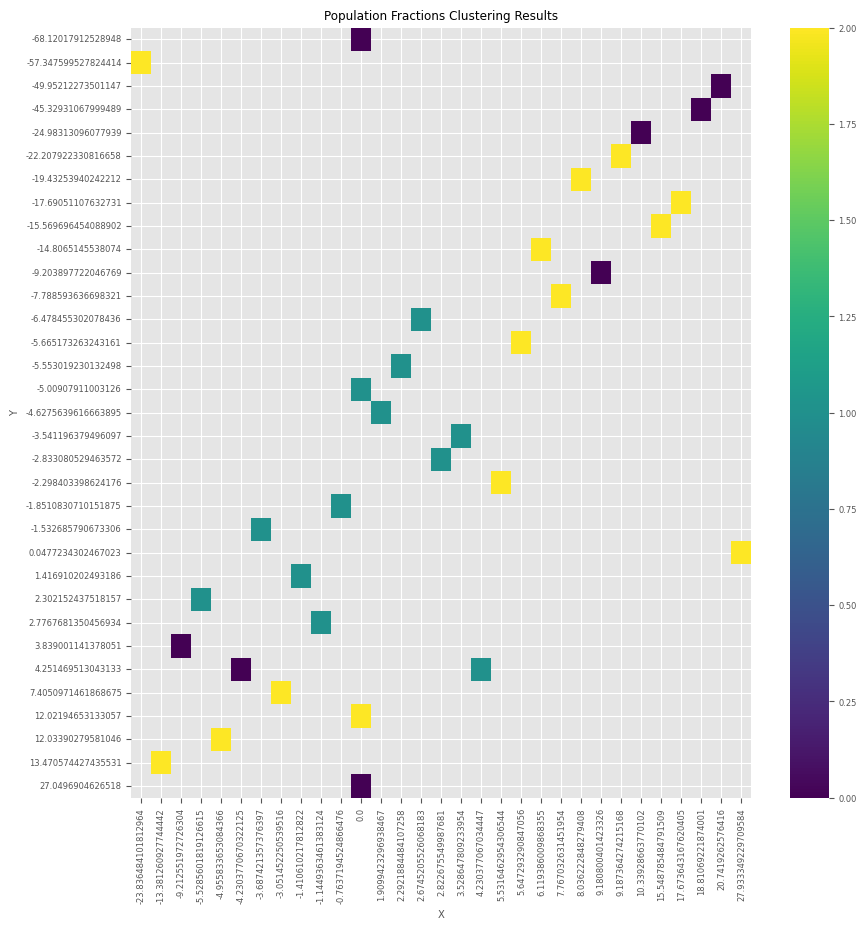

In [107]:
cluster_earlier=data_with_clusters['Cluster Label']

# compute label matching between the earlier cluster and the cluster for population fractions
label_matching_population_frac = find_best_label_matching(cluster_earlier, data['spectral_cluster_population_frac_matched'])
data_with_clusters['spectral_cluster_population_frac_matched'] = data['spectral_cluster_population_frac_matched'].map({i: j for i, j in enumerate(label_matching_population_frac)})
data_with_clusters['spectral_cluster_population_frac_matched'] = data_with_clusters['spectral_cluster_population_frac_matched'].astype(int)

# print the best label matching
print('Best Label Matching for Earlier Cluster and Population Fractions:')
print(label_matching_population_frac)

# compute the NMI between the earlier cluster and the cluster for population fractions
nmi_population_frac = NMI(cluster_earlier, data_with_clusters['spectral_cluster_population_frac_matched'])

# print the NMI between the earlier cluster and the cluster for population fractions
print(f'NMI between Earlier Cluster and Population Fractions: {nmi_population_frac:.5f}')
# compute the ARI between the earlier cluster and the cluster for population fractions
ari_population_frac = ARI(cluster_earlier, data_with_clusters['spectral_cluster_population_frac_matched'])
print(f'ARI between Earlier Cluster and Population Fractions: {ari_population_frac:.5f}')

# find the number of pairwise matches between the earlier cluster and the cluster for population fractions
matches_population_frac = np.where(cluster_earlier == data_with_clusters['spectral_cluster_population_frac_matched'])[0]

print(f'Number of pairwise matches between Earlier Cluster and Population Fractions: {len(matches_population_frac)}')
print(f'Index of pairwise matches between Earlier Cluster and Population Fractions: {matches_population_frac}')

# compute correlation between the earlier cluster and the cluster for population fractions
correlation_population_frac = np.corrcoef(cluster_earlier, data_with_clusters['spectral_cluster_population_frac_matched'])[0, 1]

# print the correlation between the earlier cluster and the cluster for population fractions
print(f'Correlation between Earlier Cluster and Population Fractions: {correlation_population_frac:.5f}')

# show the heatmap of population fractions using LISA
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(data_with_clusters.pivot_table(index='cart_y', columns='cart_x', values='spectral_cluster_population_frac_matched', aggfunc='first'), cmap='viridis', ax=ax)
plt.title('Population Fractions Clustering Results')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()




In [108]:
coord=np.array([[data.iloc[i]['cart_x'],data.iloc[i]['cart_y']] for i in range(len(data))])
coord

array([[-4.23037707e+00,  4.25146951e+00],
       [-9.21255197e+00,  3.83900114e+00],
       [ 0.00000000e+00,  2.70496905e+01],
       [ 2.79333492e+01,  4.77234302e-02],
       [ 0.00000000e+00,  1.20219465e+01],
       [-5.52856018e+00,  2.30215244e+00],
       [-4.95583365e+00,  1.20339028e+01],
       [ 7.76703263e+00, -7.78859364e+00],
       [ 5.64729329e+00, -5.66517326e+00],
       [-1.33812609e+01,  1.34705744e+01],
       [ 8.03622285e+00, -1.94325394e+01],
       [ 6.11938601e+00, -1.48065146e+01],
       [ 9.18736427e+00, -2.22079223e+01],
       [ 9.18080040e+00, -9.20389772e+00],
       [ 1.76736432e+01, -1.76905111e+01],
       [-1.41061022e+00,  1.41691020e+00],
       [ 4.23037707e+00,  4.25146951e+00],
       [-1.14493635e+00,  2.77676814e+00],
       [-3.05145225e+00,  7.40509715e+00],
       [-3.68742136e+00, -1.53268579e+00],
       [ 3.52864781e+00, -3.54119638e+00],
       [ 1.88106922e+01, -4.53293107e+01],
       [-2.38364841e+01, -5.73475995e+01],
       [-7.

Local Moran's I values: [-0.35507968 -0.33613279  0.10854632  0.57135555  0.05323489 -0.78240569
 -0.30051113 -0.15627571  0.12480335  0.32284002 -0.18965254  0.00428461
  0.29015092 -0.15096376  0.36472589  0.03306943  0.27237346  0.3790121
 -0.16414101 -0.72501333  0.08815386  0.71348593  1.20775882 -0.43432344
  0.11570726  0.23825649  1.34912206 -0.00220629 -0.61529189 -0.28907522
  0.06886585  1.2741799  -0.46504331 -0.07522241]
p-values: [0.066 0.138 0.256 0.16  0.365 0.35  0.195 0.354 0.166 0.289 0.06  0.474
 0.159 0.398 0.289 0.35  0.299 0.049 0.368 0.014 0.4   0.022 0.013 0.118
 0.334 0.306 0.018 0.317 0.122 0.349 0.146 0.004 0.274 0.353]
Clusters/Outliers classification: [1 2 3 3 3 3]


C:\Users\subha\AppData\Local\Temp\ipykernel_7768\3002148308.py:25: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  'geometry': [lps.cg.Point(c) for c in coord]


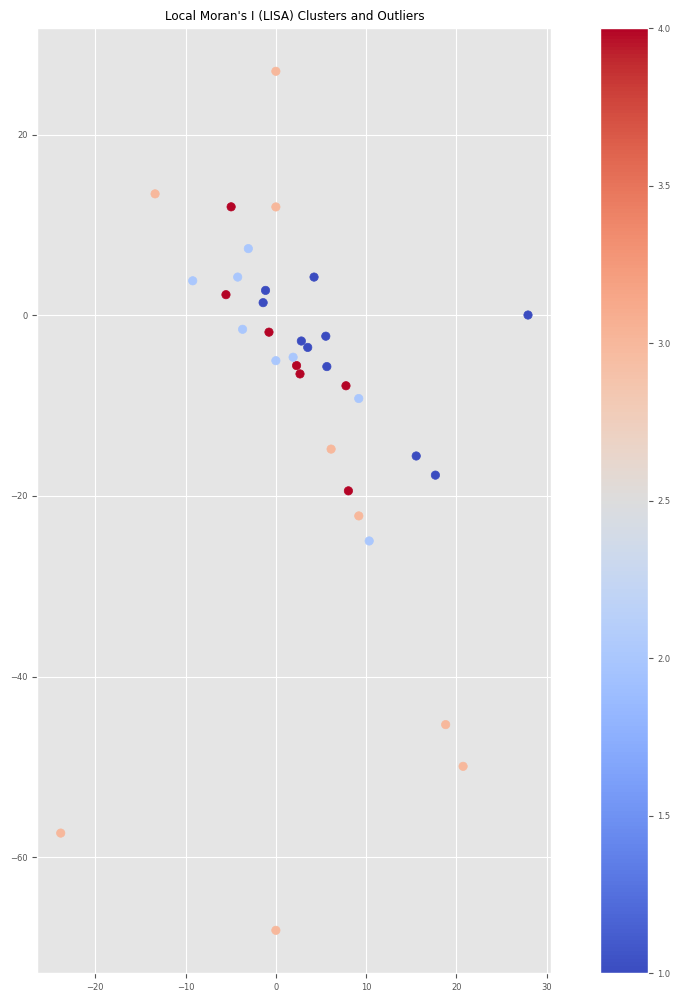

Significant clusters at indices: [1 2 3 3 3 3]


In [109]:
import numpy as np
import libpysal as lps
import esda
import geopandas as gpd
import matplotlib.pyplot as plt

# Example data: values (e.g., population density) for different spatial units
# Assume 'population_density' and 'suburb_coords' are defined
# 
# Calculate Local Moran's I
lisa = esda.Moran_Local(data['suburb_services_score'], w)

# Output the Local Moran's I statistic for each point
print("Local Moran's I values:", lisa.Is)
print("p-values:", lisa.p_sim)

# Identify clusters and outliers
# Local clusters where p-value < 0.05 (typically interpreted as significant)
significant_clusters = lisa.q[lisa.p_sim < 0.05]
print("Clusters/Outliers classification:", significant_clusters)

# Create a GeoDataFrame for visualization
gdf_temp1 = gpd.GeoDataFrame({
    'lisa': lisa.q,
    'geometry': [lps.cg.Point(c) for c in coord]
})

# Plot the LISA result using GeoDataFrame's plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_temp1.plot(
    column='lisa',
    cmap='coolwarm',
    legend=True,
    ax=ax
)
ax.set_title("Local Moran's I (LISA) Clusters and Outliers")
plt.tight_layout()
plt.show()

print("Significant clusters at indices:", significant_clusters)


c:\Users\subha\miniconda3\Lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


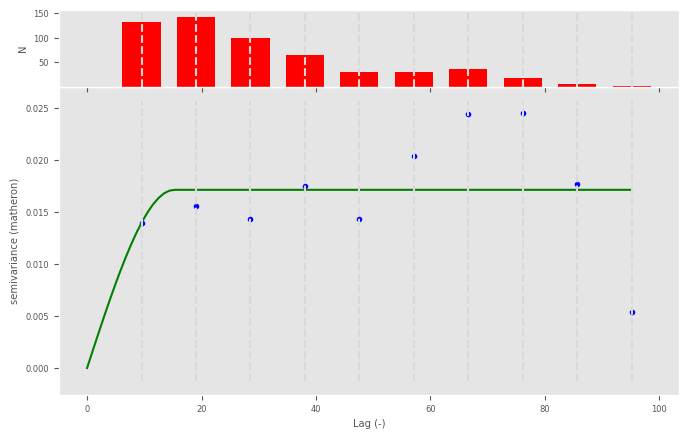

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': np.float64(1449.7073651789078), 'normalized_sill': np.float64(0.0004188924138592511), 'normalized_nugget': 0, 'effective_range': np.float64(15.23283967347788), 'sill': np.float64(0.017123096240689594), 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': None, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}


In [110]:
# plot variogram
from skgstat import Variogram
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
values = data['suburb_services_score']
variogram = Variogram(coords, values)
variogram.plot()
plt.show()
print(variogram.describe())

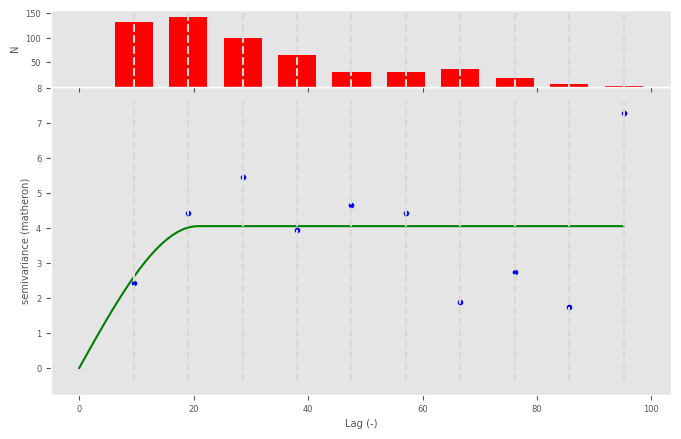

{'model': 'spherical', 'estimator': 'matheron', 'dist_func': 'euclidean', 'normalized_effective_range': np.float64(1972.0394780990403), 'normalized_sill': np.float64(29.490925883560617), 'normalized_nugget': 0, 'effective_range': np.float64(20.72125859410563), 'sill': np.float64(4.053920937787883), 'nugget': 0, 'params': {'estimator': 'matheron', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': None, 'n_lags': 10, 'verbose': False}, 'kwargs': {}}


In [111]:
# plot variogram for significant features for population fractions
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
values = data['2012 ERP age 5-9, %']
variogram = Variogram(coords, values)
variogram.plot()
plt.show()
print(variogram.describe())


Local Moran's I values: [-0.10549116  0.0955158   1.61360071  0.01780826  0.42359089  0.03484352
  0.09039744  0.18003797 -0.15584946  1.35549257  0.26589326  0.02624794
  0.42989874  0.18389372  0.05342571  1.07003621 -0.2718194   0.93048317
 -0.50636558  0.61011194  1.41569257  0.97293905 -0.31217659  0.93840284
  1.62931366  0.01419352  0.15259266  0.28639928  1.70887558  1.68775762
  0.47681468  0.85439071  0.63351449  2.18764736]
p-values: [0.197 0.373 0.017 0.353 0.174 0.473 0.091 0.28  0.366 0.089 0.082 0.222
 0.099 0.212 0.284 0.022 0.024 0.146 0.221 0.051 0.012 0.03  0.113 0.026
 0.016 0.303 0.214 0.002 0.02  0.02  0.125 0.036 0.211 0.004]
Clusters/Outliers classification: [1 3 4 3 1 3 3 3 3 3 1 3]


C:\Users\subha\AppData\Local\Temp\ipykernel_7768\2228634493.py:25: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  'geometry': [lps.cg.Point(c) for c in coord]


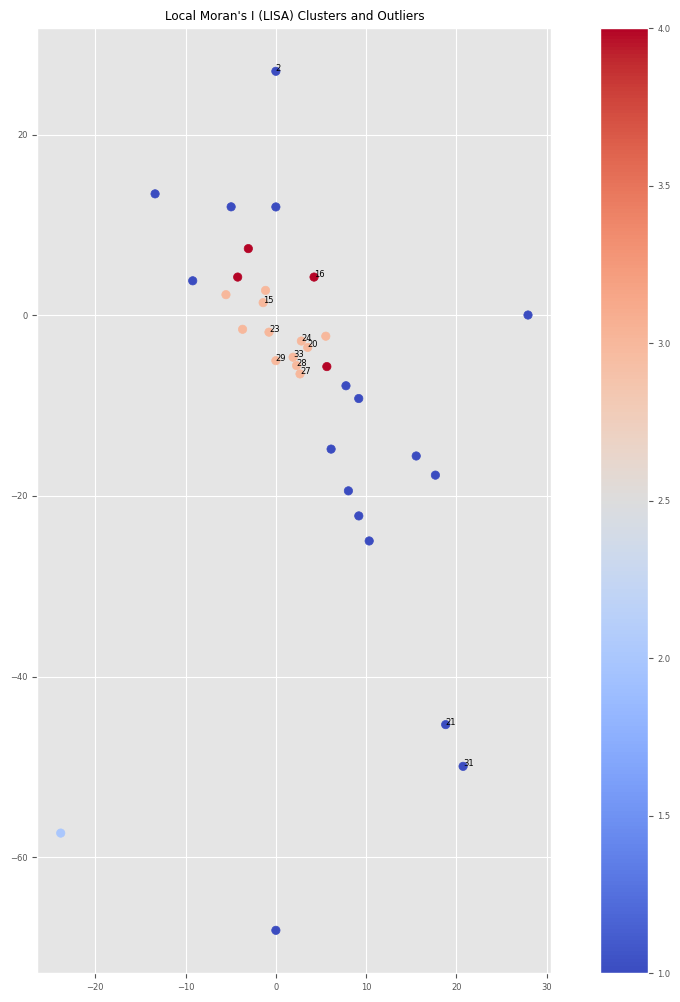

Significant clusters at indices: [ 2 15 16 20 21 23 24 27 28 29 31 33]


In [112]:
import numpy as np
import libpysal as lps
import esda
import geopandas as gpd
import matplotlib.pyplot as plt

# Example data: values (e.g., population density) for different spatial units
# Assume 'population_density' and 'suburb_coords' are defined
# 
# Calculate Local Moran's I
lisa = esda.Moran_Local(data['2012 ERP age 5-9, %'], w)

# Output the Local Moran's I statistic for each point
print("Local Moran's I values:", lisa.Is)
print("p-values:", lisa.p_sim)

# Identify clusters and outliers
# Local clusters where p-value < 0.05 (typically interpreted as significant)
significant_clusters = lisa.q[lisa.p_sim < 0.05]
print("Clusters/Outliers classification:", significant_clusters)

# Create a GeoDataFrame for visualization
gdf_temp2 = gpd.GeoDataFrame({
    'lisa': lisa.q,
    'geometry': [lps.cg.Point(c) for c in coord]
})

# Plot the LISA result using GeoDataFrame's plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_temp2.plot(
    column='lisa',
    cmap='coolwarm',
    legend=True,
    ax=ax
)
ax.set_title("Local Moran's I (LISA) Clusters and Outliers")
# annotate significant points with the suburb index
for i in np.where(lisa.p_sim < 0.05)[0]:
    ax.annotate(i, (gdf_temp2.geometry.x[i], gdf_temp2.geometry.y[i]), color='black')
plt.tight_layout()
plt.show()

print("Significant clusters at indices:", np.where(lisa.p_sim < 0.05)[0])


In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import libpysal as ps
from esda.moran import Moran
import geopandas as gpd
from shapely.geometry import Point
import esda as es

# Compute spatial weights using Euclidean distance with a specified threshold (default behavior)
w_new = ps.weights.DistanceBand.from_dataframe(gdf, threshold=10, silence_warnings=True, binary=False)

# Compute Moran's I for the population density (or suburb services score)
moran = Moran(data['suburb_services_score'].values, w_new, permutations=9999)
print('Moran\'s I:', moran.I)
print('P-value:', moran.p_sim)

# Compute Geary's C for the population density (or suburb services score)
geary = es.Geary(data['suburb_services_score'].values, w_new, permutations=9999)
print('Geary\'s C:', geary.C)
print('P-value:', geary.p_sim)


Moran's I: 0.02471824294715066
P-value: 0.2774
Geary's C: 0.8868510146083343
P-value: 0.2208


In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import libpysal as ps
from esda.moran import Moran
import geopandas as gpd
from shapely.geometry import Point
import esda as es

# Compute spatial weights using Euclidean distance with a specified threshold (default behavior)
w_new = ps.weights.DistanceBand.from_dataframe(gdf, threshold=29.49, silence_warnings=True, binary=False)

# Compute Moran's I for the population density (or suburb services score)
moran = Moran(data['2012 ERP age 5-9, %'].values, w_new, permutations=9999)
print('Moran\'s I:', moran.I)
print('P-value:', moran.p_sim)

# Compute Geary's C for the population density (or suburb services score)
geary = es.Geary(data['2012 ERP age 5-9, %'].values, w_new, permutations=9999)
print('Geary\'s C:', geary.C)
print('P-value:', geary.p_sim)


Moran's I: 0.21890448365173237
P-value: 0.0011
Geary's C: 0.7727962177821845
P-value: 0.0057


Local Moran's I values: [-0.07638909 -0.18423624  0.23460648 -0.03430698 -0.13913692  0.21394697
  0.00187082 -0.15873776 -0.32440839 -0.54018427  0.00805322 -0.00882565
  0.08155661 -0.07213845 -0.01162232  0.53405688 -0.08993155  0.62154093
 -0.29693304  0.32252887  0.77513559  0.74931827 -0.15146285  0.50081261
  0.92374598 -0.00478269  0.06613012  0.13579162  0.95389251  0.92303985
  0.35795831  0.8167048  -0.0080997   1.1043534 ]
p-values: [0.026 0.035 0.197 0.005 0.197 0.055 0.47  0.08  0.001 0.12  0.457 0.099
 0.261 0.198 0.37  0.001 0.001 0.016 0.061 0.001 0.001 0.071 0.381 0.001
 0.001 0.295 0.406 0.001 0.001 0.001 0.001 0.086 0.433 0.001]
Clusters/Outliers classification: [4 4 4 4 3 4 3 3 3 3 3 3 3 3 3 3]


C:\Users\subha\AppData\Local\Temp\ipykernel_7768\2307473694.py:15: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  'geometry': [lps.cg.Point(c) for c in coord]


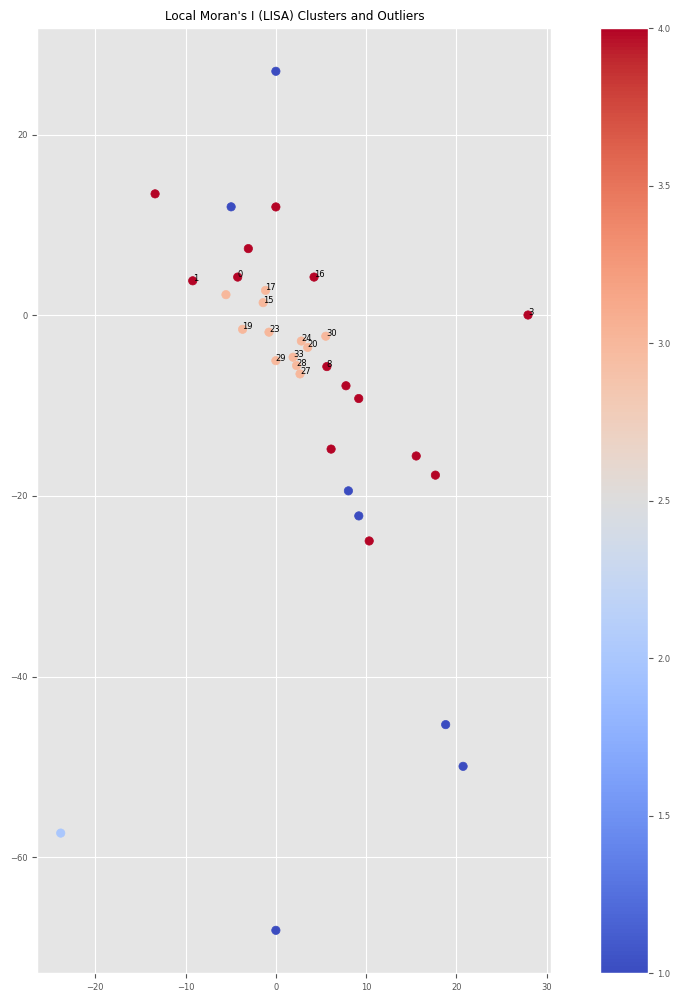

Significant clusters at indices: [ 0  1  3  8 15 16 17 19 20 23 24 27 28 29 30 33]


In [132]:
lisa = esda.Moran_Local(data['2012 ERP age 5-9, %'], w_new)

# Output the Local Moran's I statistic for each point
print("Local Moran's I values:", lisa.Is)
print("p-values:", lisa.p_sim)

# Identify clusters and outliers
# Local clusters where p-value < 0.05 (typically interpreted as significant)
significant_clusters = lisa.q[lisa.p_sim < 0.05]
print("Clusters/Outliers classification:", significant_clusters)

# Create a GeoDataFrame for visualization
gdf_temp2 = gpd.GeoDataFrame({
    'lisa': lisa.q,
    'geometry': [lps.cg.Point(c) for c in coord]
})

# Plot the LISA result using GeoDataFrame's plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_temp2.plot(
    column='lisa',
    cmap='coolwarm',
    legend=True,
    ax=ax
)
ax.set_title("Local Moran's I (LISA) Clusters and Outliers")
# annotate significant points with the suburb index
for i in np.where(lisa.p_sim < 0.05)[0]:
    ax.annotate(i, (gdf_temp2.geometry.x[i], gdf_temp2.geometry.y[i]), color='black')
plt.tight_layout()
plt.show()

print("Significant clusters at indices:", np.where(lisa.p_sim < 0.05)[0])
